### Plate convergence

Our results suggest that there are a number of deformational modes of the model mantle lithosphere: 

- a dripping or Rayleigh-Taylor–type instability; 
- an asymmetric nderthrusting or subduction; 
- symmetric, ablative plate consumption; 
- slab breakoff, the failure and detachment of the strong lithosphere; and 
- mixed modes with combinations of these processes. 

The development of the modes is controlled by the rate of convergence associated with the background tectonic regime, the density field, and the rheology of the mantle lithosphere. 

<img src="F_Pysklywec2000_ModelSetup.png" alt="Drawing" style="width: 500px;"/> 

### Reference
- Pysklywec, R. N., Beaumont, C., & Fullsack, P. (2000). Modeling the behavior of the continental mantle lithosphere during plate convergence. Geology, 28(7), 655-658.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
import underworld as uw
from underworld import function as fn

import numpy as np
import math
u = GEO.UnitRegistry
GEO.__version__

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


'2.12.1'

In [2]:
velocity = 1.5 * u.centimetre / u.year

# Scaling
T0 = 293.15 * u.degK # 20 * u.degC
Tz = 1733.15 * u.degK # 1500 * u.degC

K_viscosity = 1e20  * u.pascal * u.second
K_density = 3300 * u.kilogram / (u.meter)**3
KL = 2400 * u.kilometer
KH = 600 * u.kilometer
K_gravity =  10. * u.meter / u.second**2

Kt = KL /velocity
bodyforce = K_density  * K_gravity 
KM = bodyforce * KL**2 * Kt**2
KT = Tz - T0

GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[length]"] = KH
GEO.scaling_coefficients["[mass]"] = KM
GEO.scaling_coefficients["[temperature]"] = KT
    
GEO.rcParams["swarm.particles.per.cell.2D"]= 20    
# Model mesh
Model = GEO.Model(elementRes=(200,50),
                  minCoord=(0. * u.kilometer, -600. * u.kilometer),  
                  maxCoord=(2400 * u.kilometer,0. * u.kilometer ),
                  gravity=(0.0, -K_gravity))

Model.outputDir= "op_Pysklywec2010simpleReh_uwg"
Model.minStrainRate = 1e-18 / u.second

resolution0 = 12.0 * u.kilometer

	Global element size: 200x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 200x50
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"


In [3]:
D_crust = GEO.nd(-24 * u.kilometer)
D_ml = GEO.nd(-120* u.kilometer)
D_Bottom = GEO.nd(-KH)

SL_ws =  GEO.nd(12 * u.kilometer) 
X_ws0 = GEO.nd(1200 * u.kilometer) - SL_ws/2.
X_ws1 = GEO.nd(1200 * u.kilometer) + SL_ws/2. 
Y_ws0 = GEO.nd(-42 * u.kilometer) + SL_ws/2.
Y_ws1 = GEO.nd(-42 * u.kilometer) - SL_ws/2. 

crust       = Model.add_material(name="Crust", shape=GEO.shapes.Layer2D(top=Model.top, bottom=D_crust))
ml = Model.add_material(name="Mantle lithosphere0", shape=GEO.shapes.Layer2D(top=D_crust, bottom=D_ml))
ma = Model.add_material(name="Asthenosphere", shape=GEO.shapes.Layer2D(top=D_ml, bottom=Model.bottom))
weakseed = Model.add_material(name="Week seed", shape=GEO.shapes.Box(Y_ws0, Y_ws1, minX=X_ws0, maxX=X_ws1))

In [4]:
npoints = 250
coords0 = np.ndarray((npoints, 2))
coords0[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords0[:, 1] = D_crust

coords1 = np.ndarray((npoints, 2))
coords1[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords1[:, 1] = D_ml

Model.add_passive_tracers(name="interface0", vertices=coords0)
Model.add_passive_tracers(name="interface1", vertices=coords1)


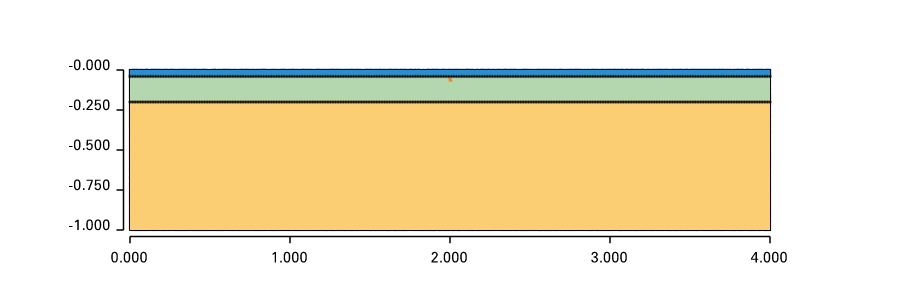

In [5]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70)
Fig.Points(Model.interface0_tracers, pointSize=4.0)
Fig.Points(Model.interface1_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()

In [6]:
# Viscous rheology
Model.maxViscosity = 1e23 * u.pascal * u.second
Model.minViscosity = 1e20 * u.pascal * u.second

crust.viscosity    = 1e23 * u.pascal * u.second
weakseed.viscosity = 1e20 * u.pascal * u.second
ml.viscosity      = 1e21 * u.pascal * u.second
ma.viscosity      = 1e20 * u.pascal * u.second


# Density (Pysklywec2002)
crust.density = 2800. * u.kilogram / u.metre**3                                                     
ml.density   = 3300. * u.kilogram / u.metre**3
ma.density    = 3300. * u.kilogram / u.metre**3    
weakseed.density = 3300. * u.kilogram / u.metre**3

#Thermol
# Model.capacity = 750. * u.joule / (u.kelvin * u.kilogram)
# crust.capacity = 750. * u.joule / (u.kelvin * u.kilogram)
# ml.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)
# ma.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)
# weakseed.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)

# Model.diffusivity = 1.0e-6 * u.metre**2 / u.second 
# crust.diffusivity = 1.0e-6 * u.metre**2 / u.second 
# ml.diffusivity = 1.0e-6 * u.metre**2 / u.second 
# ma.diffusivity = 1.0e-6 * u.metre**2 / u.second 
# weakseed.diffusivity = 1.0e-6 * u.metre**2 / u.second 

In [7]:
Vx  = GEO.nd(velocity)
Vxb = np.abs(-Vx *D_ml/2/(-D_Bottom-D_ml))

conditions0 = [(Model.y >= D_ml, GEO.nd(0.0 * u.centimetre/u.year)),
            (True, -Vxb)]
function0 = fn.branching.conditional(conditions0)

conditions1 = [(Model.y > D_ml, -Vx),
               (Model.y == D_ml, GEO.nd(0.0 * u.centimetre/u.year)),
              (True, Vxb)]
function1 = fn.branching.conditional(conditions1)

Model.set_velocityBCs(left=[function0, None],
                      right=[function1, None],
                      bottom=[None, 0.],
                      top=[None,None],
                      order_wall_conditions=[ "left", "right","top", "bottom"])

#surface_nodes = GEO.shapes.Layer2D(top=0.+resolution0/4, bottom=0.-resolution0/4)

# Model.set_temperatureBCs(top=T0 ,
#                          bottom=Tz,nodeSets=[(surface_nodes,T0)])

In [8]:
# T0 = 293.15 * u.degK
# T1 = 693.15 * u.degK
# T2 = 1623.15 * u.degK
# Tz = 1773.15 * u.degK 

# crust_geotherm        = GEO.nd(T0) + GEO.nd(T1-T0)*(Model.y)/D_crust
# lithosphere_geotherm  = GEO.nd(T1) + GEO.nd(T2-T1)*(Model.y -D_crust)/(D_ml-D_crust)
# mantle_geotherm       = GEO.nd(T2) + GEO.nd(Tz-T2)*(Model.y - D_ml)/(D_Bottom-D_ml)

# geotherm_fn = fn.branching.conditional([(Model.y >= D_crust,crust_geotherm),
#                                         (Model.y >= D_ml,lithosphere_geotherm),
#                                         (True, mantle_geotherm)])

# Model.init_model(temperature=geotherm_fn)
Model.init_model(pressure="lithostatic",temperature=False)

In [9]:
# Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
# #Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True)
# # Fig.Points(surf_tracers, pointSize=4.0)
# # Fig.Points(moho_tracers, pointSize=4.0)
# Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
# Fig.Contours(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), interval= 150, limits=(293.15,1773.15),colours='Black', colourBar=False)
# Fig.show()


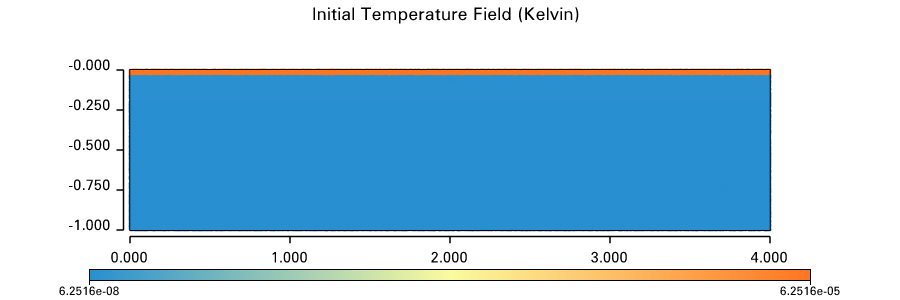

In [10]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
Fig.Points(Model.swarm,Model.viscosityField,pointSize=4.0,colourBar = True)#colours="jet" ,
Fig.show()

In [11]:
Model.freeSurface = True
#Model.fssa_factor = 1.0

	Global element size: 200x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 200x50


In [12]:
Model.solver.set_inner_method("mumps")
#Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 5e-2

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [13]:
# checkpoint_interval = 0.005*u.megayears

# def plot_fig():
#     global FigMat
#     if GEO.nd(Model.time)%GEO.nd(checkpoint_interval)==0:
#     #if GEO.nd(Model.step)%GEO.nd(checkpoint_interval)==0:
        
        
# #         K_L = 192e3
# #         x,y = surftracer.data[:,0]*K_L/1000,Model.surface_tracers.data[:,1]*K_L/1000
# #         fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
# #         ax1.set(xlabel='Distance [km]', ylabel='Topo [km]')
# #         ax1.plot(x,y,'k')
# #         ax1.set_ylim([-2,10])
# #         ax1.set_xlim([0,192])
# #         ax1.grid()
# #         plt.savefig(Model.outputDir+"/Topo-{0}.png".format(Model.checkpointID))
# #         plt.close()
                         
#         Fig = vis.Figure(resolution=(800,400),rulers=True)
#         Fig.Points(Model.interface0_tracers, pointSize=4.0)
#         Fig.Points(Model.interface1_tracers, pointSize=4.0)
#         Fig.Points(Model.interface2_tracers, pointSize=4.0)
#         Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
#         #Fig.show()
#         Fig.save(Model.outputDir+"/Material-{0}.png".format(Model.checkpointID))
# Model.post_solve_functions["plot_fig"] = plot_fig

In [14]:
#Model.run_for(nstep=10, checkpoint_interval=1)#,dt=0.01*u.megayears)
#Model.run_for(1.6 * u.megayears, checkpoint_interval=checkpoint_interval,dt=checkpoint_interval)

In [15]:
Model.run_for(1.6 * u.megayears, checkpoint_interval=0.1*u.megayears,dt=1000*u.year)
#Model.run_for(6.4 * u.megayears, checkpoint_interval=0.1*u.megayears,dt=2500*u.year)
#Model.run_for(5.5 * u.megayears, checkpoint_interval=100000*u.year,dt=5000*u.year)

Running with UWGeodynamics version 2.12.1
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02586 secs / 1 its
  Pressure Solve:         = 0.09262 secs / 3 its
  Final V Solve:          = 0.02741 secs / 1 its

  Total BSSCR Linear solve time: 0.421293 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.226680e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.1373 [min] /    0.1373 [max] (secs)
Time Integration - 0.1

Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241 [min] / 0.000241 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000204978 [min] / 0.000204978 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:     6 Model Time: 6000.0 year dt: 1000.0 year (2022-05-23 19:08:22)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01248 secs / 1 its
  Pressure Solve:         = 0.104 secs / 9 its
  Final V Solve:          = 0.009045 secs / 1 its

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3746 [min] /    0.3746 [max] (secs)
Time Integration - 0.374691 [min] / 0.374691 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.178956e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242362 [min] / 0.000242362 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000207301 [min] / 0.000207301 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    12 Model Time: 12000.0 year dt: 1000.0 year (2022-05-23 19:08:36)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3452 [min] /    0.3452 [max] (secs)
Time Integration - 0.345241 [min] / 0.345241 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.218329e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000265983 [min] / 0.000265983 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000213908 [min] / 0.000213908 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    18 Model Time: 18000.0 year dt: 1000.0 year (2022-05-23 19:08:49)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3366 [min] /    0.3366 [max] (secs)
Time Integration - 0.336612 [min] / 0.336612 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.341018e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000477212 [min] / 0.000477212 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000440513 [min] / 0.000440513 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    24 Model Time: 24000.0 year dt: 1000.0 year (2022-05-23 19:09:03)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4304 [min] /    0.4304 [max] (secs)
Time Integration - 0.430413 [min] / 0.430413 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.329299e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00039115 [min] / 0.00039115 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205096 [min] / 0.000205096 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    30 Model Time: 30000.0 year dt: 1000.0 year (2022-05-23 19:09:16)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3437 [min] /    0.3437 [max] (secs)
Time Integration - 0.343746 [min] / 0.343746 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.182584e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256101 [min] / 0.000256101 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000212966 [min] / 0.000212966 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    36 Model Time: 36000.0 year dt: 1000.0 year (2022-05-23 19:09:30)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3385 [min] /    0.3385 [max] (secs)
Time Integration - 0.338522 [min] / 0.338522 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.612908e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251811 [min] / 0.000251811 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000211271 [min] / 0.000211271 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    42 Model Time: 42000.0 year dt: 1000.0 year (2022-05-23 19:09:43)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4242 [min] /    0.4242 [max] (secs)
Time Integration - 0.424257 [min] / 0.424257 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.177409e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245315 [min] / 0.000245315 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000220454 [min] / 0.000220454 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    48 Model Time: 48000.0 year dt: 1000.0 year (2022-05-23 19:09:57)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4464 [min] /    0.4464 [max] (secs)
Time Integration - 0.446403 [min] / 0.446403 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.328399e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253761 [min] / 0.000253761 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000207548 [min] / 0.000207548 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    54 Model Time: 54000.0 year dt: 1000.0 year (2022-05-23 19:10:11)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3922 [min] /    0.3922 [max] (secs)
Time Integration - 0.392214 [min] / 0.392214 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.552183e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000423835 [min] / 0.000423835 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000396407 [min] / 0.000396407 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    60 Model Time: 60000.0 year dt: 1000.0 year (2022-05-23 19:10:25)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4297 [min] /    0.4297 [max] (secs)
Time Integration - 0.429786 [min] / 0.429786 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.341941e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000263879 [min] / 0.000263879 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000200811 [min] / 0.000200811 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    66 Model Time: 66000.0 year dt: 1000.0 year (2022-05-23 19:10:39)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3713 [min] /    0.3713 [max] (secs)
Time Integration - 0.371363 [min] / 0.371363 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.205765e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000258087 [min] / 0.000258087 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231925 [min] / 0.000231925 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    72 Model Time: 72000.0 year dt: 1000.0 year (2022-05-23 19:10:53)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3613 [min] /    0.3613 [max] (secs)
Time Integration - 0.361354 [min] / 0.361354 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.259012e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000244768 [min] / 0.000244768 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000208688 [min] / 0.000208688 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    78 Model Time: 78000.0 year dt: 1000.0 year (2022-05-23 19:11:08)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3585 [min] /    0.3585 [max] (secs)
Time Integration - 0.35855 [min] / 0.35855 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.531934e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246496 [min] / 0.000246496 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000219456 [min] / 0.000219456 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    84 Model Time: 84000.0 year dt: 1000.0 year (2022-05-23 19:11:22)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4310 [min] /    0.4310 [max] (secs)
Time Integration - 0.431043 [min] / 0.431043 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 2.461289e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000318177 [min] / 0.000318177 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000225346 [min] / 0.000225346 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    90 Model Time: 90000.0 year dt: 1000.0 year (2022-05-23 19:11:35)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3957 [min] /    0.3957 [max] (secs)
Time Integration - 0.395772 [min] / 0.395772 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.134813e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254842 [min] / 0.000254842 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000465001 [min] / 0.000465001 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:    96 Model Time: 96000.0 year dt: 1000.0 year (2022-05-23 19:11:49)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Step:   101 Model Time: 100000.0 year dt: 0.0 second (2022-05-23 19:12:12)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02013 secs / 1 its
  Pressure Solve:         = 0.1191 secs / 10 its
  Final V Solve:          = 0.008291 secs / 1 its

  Total BSSCR Linear solve time: 0.372755 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.734686e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4169 [min] /    0.4169 [max] (secs)
Time Integration - 0.416966 [min] / 0.416966 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.355785e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259167 [min] / 0.000259167 [m

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01246 secs / 1 its
  Pressure Solve:         = 0.1154 secs / 10 its
  Final V Solve:          = 0.008905 secs / 1 its

  Total BSSCR Linear solve time: 0.310841 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.117879e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3880 [min] /    0.3880 [max] (secs)
Time Integration - 0.388021 [min] / 0.388021 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.218140e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000479383 [min] / 0.000479383 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Step:   113 Model Time: 112000.0 year dt: 1000.0 year (2022-05-23 19:12:43)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01965 secs / 1 its
  Pressure Solve:         = 0.1609 secs / 10 its
  Final V Solve:          = 0.01328 secs / 1 its

  Total BSSCR Linear solve time: 0.414568 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.154094e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3952 [min] /    0.3952 [max] (secs)
Time Integration - 0.395221 [min] / 0.395221 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.379746e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241153 [min] / 0.000241153 [m

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0128 secs / 1 its
  Pressure Solve:         = 0.1159 secs / 10 its
  Final V Solve:          = 0.008627 secs / 1 its

  Total BSSCR Linear solve time: 0.288547 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.893360e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3515 [min] /    0.3515 [max] (secs)
Time Integration - 0.351581 [min] / 0.351581 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.199584e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256468 [min] / 0.000256468 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02178 secs / 1 its
  Pressure Solve:         = 0.1607 secs / 10 its
  Final V Solve:          = 0.01288 secs / 1 its

  Total BSSCR Linear solve time: 0.408482 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.092122e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4294 [min] /    0.4294 [max] (secs)
Time Integration - 0.429415 [min] / 0.429415 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.199048e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253036 [min] / 0.000253036 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01392 secs / 1 its
  Pressure Solve:         = 0.1614 secs / 10 its
  Final V Solve:          = 0.01334 secs / 1 its

  Total BSSCR Linear solve time: 0.352488 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.532402e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4749 [min] /    0.4749 [max] (secs)
Time Integration - 0.474908 [min] / 0.474908 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.577748e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025184 [min] / 0.00025184 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0219 secs / 1 its
  Pressure Solve:         = 0.1234 secs / 10 its
  Final V Solve:          = 0.008826 secs / 1 its

  Total BSSCR Linear solve time: 0.353755 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.545655e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3583 [min] /    0.3583 [max] (secs)
Time Integration - 0.358363 [min] / 0.358363 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.187007e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000234678 [min] / 0.000234678 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01939 secs / 1 its
  Pressure Solve:         = 0.185 secs / 10 its
  Final V Solve:          = 0.01259 secs / 1 its

  Total BSSCR Linear solve time: 0.428343 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.291284e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3859 [min] /    0.3859 [max] (secs)
Time Integration - 0.385977 [min] / 0.385977 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.193077e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245882 [min] / 0.000245882 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Step:   149 Model Time: 148000.0 year dt: 1000.0 year (2022-05-23 19:14:07)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01185 secs / 1 its
  Pressure Solve:         = 0.1116 secs / 10 its
  Final V Solve:          = 0.00834 secs / 1 its

  Total BSSCR Linear solve time: 0.356097 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.570079e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4170 [min] /    0.4170 [max] (secs)
Time Integration - 0.417094 [min] / 0.417094 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.358592e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231644 [min] / 0.000231644 [m

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0208 secs / 1 its
  Pressure Solve:         = 0.1438 secs / 10 its
  Final V Solve:          = 0.008725 secs / 1 its

  Total BSSCR Linear solve time: 0.490058 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.909643e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3881 [min] /    0.3881 [max] (secs)
Time Integration - 0.388183 [min] / 0.388183 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.182692e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246719 [min] / 0.000246719 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01817 secs / 1 its
  Pressure Solve:         = 0.1445 secs / 11 its
  Final V Solve:          = 0.008136 secs / 1 its

  Total BSSCR Linear solve time: 0.384797 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.855066e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4556 [min] /    0.4556 [max] (secs)
Time Integration - 0.455735 [min] / 0.455735 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.687576e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251111 [min] / 0.000251111 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0127 secs / 1 its
  Pressure Solve:         = 0.1236 secs / 11 its
  Final V Solve:          = 0.00804 secs / 1 its

  Total BSSCR Linear solve time: 0.301891 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.028521e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3481 [min] /    0.3481 [max] (secs)
Time Integration - 0.348096 [min] / 0.348096 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.591954e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236421 [min] / 0.000236421 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02129 secs / 1 its
  Pressure Solve:         = 0.1405 secs / 10 its
  Final V Solve:          = 0.008842 secs / 1 its

  Total BSSCR Linear solve time: 0.386330 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.870764e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3874 [min] /    0.3874 [max] (secs)
Time Integration - 0.387395 [min] / 0.387395 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.186640e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024193 [min] / 0.00024193 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   179 Model Time: 178000.0 year dt: 1000.0 year (2022-05-23 19:15:13)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01229 secs / 1 its
  Pressure Solve:         = 0.1128 secs / 10 its
  Final V Solve:          = 0.008349 secs / 1 its

  Total BSSCR Linear solve time: 0.349495 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.502122e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3429 [min] /    0.3429 [max] (secs)
Time Integration - 0.342965 [min] / 0.342965 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02191 secs / 1 its
  Pressure Solve:         = 0.1414 secs / 10 its
  Final V Solve:          = 0.01017 secs / 1 its

  Total BSSCR Linear solve time: 0.395370 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.961063e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3892 [min] /    0.3892 [max] (secs)
Time Integration - 0.389212 [min] / 0.389212 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.381959e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256892 [min] / 0.000256892 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0183 secs / 1 its
  Pressure Solve:         = 0.1383 secs / 10 its
  Final V Solve:          = 0.008517 secs / 1 its

  Total BSSCR Linear solve time: 0.440477 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.411699e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4942 [min] /    0.4942 [max] (secs)
Time Integration - 0.49421 [min] / 0.49421 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.339987e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248283 [min] / 0.000248283 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02452 secs / 1 its
  Pressure Solve:         = 0.1447 secs / 10 its
  Final V Solve:          = 0.009173 secs / 1 its

  Total BSSCR Linear solve time: 0.411540 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.122909e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3545 [min] /    0.3545 [max] (secs)
Time Integration - 0.354539 [min] / 0.354539 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196953e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000435056 [min] / 0.000435056 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01215 secs / 1 its
  Pressure Solve:         = 0.1108 secs / 10 its
  Final V Solve:          = 0.008164 secs / 1 its

  Total BSSCR Linear solve time: 0.284469 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.851545e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3494 [min] /    0.3494 [max] (secs)
Time Integration - 0.349437 [min] / 0.349437 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.561919e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249363 [min] / 0.000249363 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   209 Model Time: 207000.0 year dt: 1000.0 year (2022-05-23 19:16:29)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01254 secs / 1 its
  Pressure Solve:         = 0.1126 secs / 10 its
  Final V Solve:          = 0.008555 secs / 1 its

  Total BSSCR Linear solve time: 0.287299 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.879982e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4414 [min] /    0.4414 [max] (secs)
Time Integration - 0.45001 [min] / 0.45001 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02075 secs / 1 its
  Pressure Solve:         = 0.1361 secs / 10 its
  Final V Solve:          = 0.008223 secs / 1 its

  Total BSSCR Linear solve time: 0.378738 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.795072e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3448 [min] /    0.3448 [max] (secs)
Time Integration - 0.34489 [min] / 0.34489 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.188456e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242839 [min] / 0.000242839 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0126 secs / 1 its
  Pressure Solve:         = 0.1236 secs / 11 its
  Final V Solve:          = 0.008824 secs / 1 its

  Total BSSCR Linear solve time: 0.297781 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.985215e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3517 [min] /    0.3517 [max] (secs)
Time Integration - 0.351787 [min] / 0.351787 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.190135e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000465153 [min] / 0.000465153 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01985 secs / 1 its
  Pressure Solve:         = 0.1352 secs / 11 its
  Final V Solve:          = 0.008485 secs / 1 its

  Total BSSCR Linear solve time: 0.367966 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.687017e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3560 [min] /    0.3560 [max] (secs)
Time Integration - 0.356024 [min] / 0.356024 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.330249e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252573 [min] / 0.000252573 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   233 Model Time: 231000.0 year dt: 1000.0 year (2022-05-23 19:17:21)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01235 secs / 1 its
  Pressure Solve:         = 0.1322 secs / 11 its
  Final V Solve:          = 0.008523 secs / 1 its

  Total BSSCR Linear solve time: 0.304423 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.051429e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4011 [min] /    0.4011 [max] (secs)
Time Integration - 0.401172 [min] / 0.401172 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01859 secs / 1 its
  Pressure Solve:         = 0.1455 secs / 11 its
  Final V Solve:          = 0.008364 secs / 1 its

  Total BSSCR Linear solve time: 0.388785 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.894754e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3413 [min] /    0.3413 [max] (secs)
Time Integration - 0.341379 [min] / 0.341379 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.165721e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239195 [min] / 0.000239195 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01257 secs / 1 its
  Pressure Solve:         = 0.122 secs / 11 its
  Final V Solve:          = 0.008435 secs / 1 its

  Total BSSCR Linear solve time: 0.341277 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.419841e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4860 [min] /    0.4860 [max] (secs)
Time Integration - 0.486013 [min] / 0.486013 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.398344e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000267549 [min] / 0.000267549 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01215 secs / 1 its
  Pressure Solve:         = 0.1245 secs / 11 its
  Final V Solve:          = 0.009092 secs / 1 its

  Total BSSCR Linear solve time: 0.354064 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.550436e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3952 [min] /    0.3952 [max] (secs)
Time Integration - 0.395261 [min] / 0.395261 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.213441e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024699 [min] / 0.00024699 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01202 secs / 1 its
  Pressure Solve:         = 0.1196 secs / 11 its
  Final V Solve:          = 0.00842 secs / 1 its

  Total BSSCR Linear solve time: 0.343004 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.436889e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3555 [min] /    0.3555 [max] (secs)
Time Integration - 0.355589 [min] / 0.355589 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.237225e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259604 [min] / 0.000259604 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0126 secs / 1 its
  Pressure Solve:         = 0.1194 secs / 11 its
  Final V Solve:          = 0.00812 secs / 1 its

  Total BSSCR Linear solve time: 0.312979 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.138625e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4296 [min] /    0.4296 [max] (secs)
Time Integration - 0.429647 [min] / 0.429647 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.346676e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241502 [min] / 0.000241502 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02389 secs / 1 its
  Pressure Solve:         = 0.1658 secs / 12 its
  Final V Solve:          = 0.008746 secs / 1 its

  Total BSSCR Linear solve time: 0.431029 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.319959e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4061 [min] /    0.4061 [max] (secs)
Time Integration - 0.40619 [min] / 0.40619 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.193386e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241404 [min] / 0.000241404 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01203 secs / 1 its
  Pressure Solve:         = 0.1269 secs / 12 its
  Final V Solve:          = 0.008173 secs / 1 its

  Total BSSCR Linear solve time: 0.347219 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.479210e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3667 [min] /    0.3667 [max] (secs)
Time Integration - 0.36676 [min] / 0.36676 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.384898e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00292854 [min] / 0.00292854 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -  

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01951 secs / 1 its
  Pressure Solve:         = 0.1582 secs / 12 its
  Final V Solve:          = 0.00827 secs / 1 its

  Total BSSCR Linear solve time: 0.403935 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.046801e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3461 [min] /    0.3461 [max] (secs)
Time Integration - 0.346098 [min] / 0.346098 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.195243e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240247 [min] / 0.000240247 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   287 Model Time: 285000.0 year dt: 1000.0 year (2022-05-23 19:19:20)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01813 secs / 1 its
  Pressure Solve:         = 0.1783 secs / 12 its
  Final V Solve:          = 0.008773 secs / 1 its

  Total BSSCR Linear solve time: 0.434268 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.350087e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3992 [min] /    0.3992 [max] (secs)
Time Integration - 0.399256 [min] / 0.399256 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01208 secs / 1 its
  Pressure Solve:         = 0.1269 secs / 12 its
  Final V Solve:          = 0.008286 secs / 1 its

  Total BSSCR Linear solve time: 0.301048 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.017717e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3426 [min] /    0.3426 [max] (secs)
Time Integration - 0.342646 [min] / 0.342646 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.346101e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251015 [min] / 0.000251015 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01233 secs / 1 its
  Pressure Solve:         = 0.1192 secs / 11 its
  Final V Solve:          = 0.008068 secs / 1 its

  Total BSSCR Linear solve time: 0.293256 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.941112e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3493 [min] /    0.3493 [max] (secs)
Time Integration - 0.349357 [min] / 0.349357 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196926e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024588 [min] / 0.00024588 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01261 secs / 1 its
  Pressure Solve:         = 0.1218 secs / 11 its
  Final V Solve:          = 0.008337 secs / 1 its

  Total BSSCR Linear solve time: 0.293659 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.944517e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3427 [min] /    0.3427 [max] (secs)
Time Integration - 0.342737 [min] / 0.342737 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.170051e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256765 [min] / 0.000256765 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01192 secs / 1 its
  Pressure Solve:         = 0.1228 secs / 11 its
  Final V Solve:          = 0.008893 secs / 1 its

  Total BSSCR Linear solve time: 0.415561 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.163145e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4003 [min] /    0.4003 [max] (secs)
Time Integration - 0.400345 [min] / 0.400345 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196604e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236858 [min] / 0.000236858 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01981 secs / 1 its
  Pressure Solve:         = 0.1657 secs / 11 its
  Final V Solve:          = 0.01223 secs / 1 its

  Total BSSCR Linear solve time: 0.415193 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.159749e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3574 [min] /    0.3574 [max] (secs)
Time Integration - 0.35749 [min] / 0.35749 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.571874e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259662 [min] / 0.000259662 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   323 Model Time: 320000.0 year dt: 1000.0 year (2022-05-23 19:20:50)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01199 secs / 1 its
  Pressure Solve:         = 0.1212 secs / 11 its
  Final V Solve:          = 0.008437 secs / 1 its

  Total BSSCR Linear solve time: 0.351275 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.520812e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3449 [min] /    0.3449 [max] (secs)
Time Integration - 0.344957 [min] / 0.344957 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01223 secs / 1 its
  Pressure Solve:         = 0.1117 secs / 10 its
  Final V Solve:          = 0.008347 secs / 1 its

  Total BSSCR Linear solve time: 0.289253 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.902225e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3422 [min] /    0.3422 [max] (secs)
Time Integration - 0.342278 [min] / 0.342278 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.180398e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261374 [min] / 0.000261374 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01227 secs / 1 its
  Pressure Solve:         = 0.1125 secs / 10 its
  Final V Solve:          = 0.0085 secs / 1 its

  Total BSSCR Linear solve time: 0.287393 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.880921e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4237 [min] /    0.4237 [max] (secs)
Time Integration - 0.423719 [min] / 0.423719 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.365204e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000255528 [min] / 0.000255528 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01873 secs / 1 its
  Pressure Solve:         = 0.1367 secs / 10 its
  Final V Solve:          = 0.008055 secs / 1 its

  Total BSSCR Linear solve time: 0.382772 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.834978e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3438 [min] /    0.3438 [max] (secs)
Time Integration - 0.343881 [min] / 0.343881 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.204701e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249803 [min] / 0.000249803 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Step:   347 Model Time: 344000.0 year dt: 1000.0 year (2022-05-23 19:21:42)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01223 secs / 1 its
  Pressure Solve:         = 0.1123 secs / 10 its
  Final V Solve:          = 0.00927 secs / 1 its

  Total BSSCR Linear solve time: 0.287224 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.879220e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3582 [min] /    0.3582 [max] (secs)
Time Integration - 0.35821 [min] / 0.35821 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.439875e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254471 [min] / 0.000254471 [max

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01222 secs / 1 its
  Pressure Solve:         = 0.1165 secs / 10 its
  Final V Solve:          = 0.01167 secs / 1 its

  Total BSSCR Linear solve time: 0.340349 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.410778e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3462 [min] /    0.3462 [max] (secs)
Time Integration - 0.346248 [min] / 0.346248 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.209127e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251673 [min] / 0.000251673 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01209 secs / 1 its
  Pressure Solve:         = 0.1189 secs / 11 its
  Final V Solve:          = 0.008178 secs / 1 its

  Total BSSCR Linear solve time: 0.289663 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.903650e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3370 [min] /    0.3370 [max] (secs)
Time Integration - 0.337079 [min] / 0.337079 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.364495e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000313308 [min] / 0.000313308 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01947 secs / 1 its
  Pressure Solve:         = 0.1634 secs / 11 its
  Final V Solve:          = 0.008464 secs / 1 its

  Total BSSCR Linear solve time: 0.406896 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.076154e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5009 [min] /    0.5009 [max] (secs)
Time Integration - 0.500993 [min] / 0.500993 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.355661e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242778 [min] / 0.000242778 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01263 secs / 1 its
  Pressure Solve:         = 0.1245 secs / 11 its
  Final V Solve:          = 0.008874 secs / 1 its

  Total BSSCR Linear solve time: 0.342020 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.430205e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3883 [min] /    0.3883 [max] (secs)
Time Integration - 0.388384 [min] / 0.388384 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.188525e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248037 [min] / 0.000248037 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01247 secs / 1 its
  Pressure Solve:         = 0.1201 secs / 11 its
  Final V Solve:          = 0.008117 secs / 1 its

  Total BSSCR Linear solve time: 0.294307 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.950166e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4332 [min] /    0.4332 [max] (secs)
Time Integration - 0.433208 [min] / 0.433208 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.359583e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256838 [min] / 0.000256838 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01201 secs / 1 its
  Pressure Solve:         = 0.1184 secs / 11 its
  Final V Solve:          = 0.009372 secs / 1 its

  Total BSSCR Linear solve time: 0.353216 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.539152e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3485 [min] /    0.3485 [max] (secs)
Time Integration - 0.348533 [min] / 0.348533 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.345278e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248896 [min] / 0.000248896 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Step:   389 Model Time: 386000.0 year dt: 1000.0 year (2022-05-23 19:23:14)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01289 secs / 1 its
  Pressure Solve:         = 0.1274 secs / 11 its
  Final V Solve:          = 0.008591 secs / 1 its

  Total BSSCR Linear solve time: 0.303708 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.044946e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3475 [min] /    0.3475 [max] (secs)
Time Integration - 0.347543 [min] / 0.347543 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.200253e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00039331 [min] / 0.00039331 [ma

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01938 secs / 1 its
  Pressure Solve:         = 0.1459 secs / 12 its
  Final V Solve:          = 0.008116 secs / 1 its

  Total BSSCR Linear solve time: 0.385594 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.862852e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3391 [min] /    0.3391 [max] (secs)
Time Integration - 0.339183 [min] / 0.339183 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.367988e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248833 [min] / 0.000248833 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01261 secs / 1 its
  Pressure Solve:         = 0.1339 secs / 12 its
  Final V Solve:          = 0.008797 secs / 1 its

  Total BSSCR Linear solve time: 0.306278 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.071502e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3745 [min] /    0.3745 [max] (secs)
Time Integration - 0.374535 [min] / 0.374535 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.206617e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024242 [min] / 0.00024242 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01207 secs / 1 its
  Pressure Solve:         = 0.1438 secs / 11 its
  Final V Solve:          = 0.01343 secs / 1 its

  Total BSSCR Linear solve time: 0.370811 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.715298e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4001 [min] /    0.4001 [max] (secs)
Time Integration - 0.40016 [min] / 0.40016 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.210032e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250609 [min] / 0.000250609 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01191 secs / 1 its
  Pressure Solve:         = 0.1121 secs / 10 its
  Final V Solve:          = 0.008571 secs / 1 its

  Total BSSCR Linear solve time: 0.335199 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.359497e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3574 [min] /    0.3574 [max] (secs)
Time Integration - 0.357418 [min] / 0.357418 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 2.656354e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000267977 [min] / 0.000267977 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02187 secs / 1 its
  Pressure Solve:         = 0.1389 secs / 10 its
  Final V Solve:          = 0.008744 secs / 1 its

  Total BSSCR Linear solve time: 0.401140 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.020865e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4109 [min] /    0.4109 [max] (secs)
Time Integration - 0.410971 [min] / 0.410971 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.226350e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246782 [min] / 0.000246782 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01201 secs / 1 its
  Pressure Solve:         = 0.1233 secs / 11 its
  Final V Solve:          = 0.00812 secs / 1 its

  Total BSSCR Linear solve time: 0.343469 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.441838e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4207 [min] /    0.4207 [max] (secs)
Time Integration - 0.420794 [min] / 0.420794 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.373166e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00026049 [min] / 0.00026049 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01249 secs / 1 its
  Pressure Solve:         = 0.1207 secs / 11 its
  Final V Solve:          = 0.008313 secs / 1 its

  Total BSSCR Linear solve time: 0.296538 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.973475e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3445 [min] /    0.3445 [max] (secs)
Time Integration - 0.344549 [min] / 0.344549 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.214237e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000546578 [min] / 0.000546578 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   437 Model Time: 434000.0 year dt: 1000.0 year (2022-05-23 19:25:12)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02526 secs / 1 its
  Pressure Solve:         = 0.1356 secs / 11 its
  Final V Solve:          = 0.00897 secs / 1 its

  Total BSSCR Linear solve time: 0.461686 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.623935e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3995 [min] /    0.3995 [max] (secs)
Time Integration - 0.399567 [min] / 0.399567 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01209 secs / 1 its
  Pressure Solve:         = 0.118 secs / 11 its
  Final V Solve:          = 0.008107 secs / 1 its

  Total BSSCR Linear solve time: 0.288329 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 2.890243e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3829 [min] /    0.3829 [max] (secs)
Time Integration - 0.38301 [min] / 0.38301 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.372621e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024891 [min] / 0.00024891 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -   

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01899 secs / 1 its
  Pressure Solve:         = 0.1741 secs / 11 its
  Final V Solve:          = 0.008144 secs / 1 its

  Total BSSCR Linear solve time: 0.424209 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.250276e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4274 [min] /    0.4274 [max] (secs)
Time Integration - 0.427399 [min] / 0.427399 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.352041e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253129 [min] / 0.000253129 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01987 secs / 1 its
  Pressure Solve:         = 0.161 secs / 12 its
  Final V Solve:          = 0.009027 secs / 1 its

  Total BSSCR Linear solve time: 0.430745 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.317058e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3941 [min] /    0.3941 [max] (secs)
Time Integration - 0.394152 [min] / 0.394152 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.208436e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259789 [min] / 0.000259789 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   461 Model Time: 458000.0 year dt: 1000.0 year (2022-05-23 19:26:06)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01267 secs / 1 its
  Pressure Solve:         = 0.166 secs / 12 its
  Final V Solve:          = 0.008813 secs / 1 its

  Total BSSCR Linear solve time: 0.375991 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.768291e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4013 [min] /    0.4013 [max] (secs)
Time Integration - 0.401392 [min] / 0.401392 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000247712 [min] / 0.000247712 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00022338 [min] / 0.00022338 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   467 Model Time: 464000.0 year dt: 1000.0 year (2022-05-23 19:26:20)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01246 secs / 1 its
  Pressure Solve:         = 0.1282 secs / 12 its
  Final V Solve:          = 0.008118 secs / 1 its

  Total

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3427 [min] /    0.3427 [max] (secs)
Time Integration - 0.342763 [min] / 0.342763 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.212526e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000484815 [min] / 0.000484815 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000427657 [min] / 0.000427657 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   473 Model Time: 470000.0 year dt: 1000.0 year (2022-05-23 19:26:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3580 [min] /    0.3580 [max] (secs)
Time Integration - 0.358095 [min] / 0.358095 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.443973e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00026219 [min] / 0.00026219 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235252 [min] / 0.000235252 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   479 Model Time: 476000.0 year dt: 1000.0 year (2022-05-23 19:26:46)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block S

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4557 [min] /    0.4557 [max] (secs)
Time Integration - 0.455802 [min] / 0.455802 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.395411e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253707 [min] / 0.000253707 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00021314 [min] / 0.00021314 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   485 Model Time: 482000.0 year dt: 1000.0 year (2022-05-23 19:26:59)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block S

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3711 [min] /    0.3711 [max] (secs)
Time Integration - 0.37116 [min] / 0.37116 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.613468e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242327 [min] / 0.000242327 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252691 [min] / 0.000252691 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   491 Model Time: 488000.0 year dt: 1000.0 year (2022-05-23 19:27:12)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block S

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3875 [min] /    0.3875 [max] (secs)
Time Integration - 0.3876 [min] / 0.3876 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.188135e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245752 [min] / 0.000245752 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000421485 [min] / 0.000421485 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   497 Model Time: 494000.0 year dt: 1000.0 year (2022-05-23 19:27:26)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Sto

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3600 [min] /    0.3600 [max] (secs)
Time Integration - 0.360035 [min] / 0.360035 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.177252e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000243454 [min] / 0.000243454 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000215339 [min] / 0.000215339 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0185 secs / 1 its
  Pressure Solve:         = 0.1453 secs / 13 its
  Final V Solve:          = 0.008132 secs / 1 its

  Total BSSCR Linear solve time: 0.398709 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.994301e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4276 [min] /    0.4276 [max] (secs)
Time Integration - 0.427669 [min] / 0.427669 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.354121e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025252 [min] / 0.00025252 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   514 Model Time: 511000.0 year dt: 1000.0 year (2022-05-23 19:28:13)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01262 secs / 1 its
  Pressure Solve:         = 0.1521 secs / 13 its
  Final V Solve:          = 0.008964 secs / 1 its

  Total BSSCR Linear solve time: 0.347017 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.477309e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3715 [min] /    0.3715 [max] (secs)
Time Integration - 0.371597 [min] / 0.371597 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259278 [min] / 0.000259278 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000213162 [min] / 0.000213162 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   520 Model Time: 517000.0 year dt: 1000.0 year (2022-05-23 19:28:26)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02117 secs / 1 its
  Pressure Solve:         = 0.1607 secs / 13 its
  Final V Solve:          = 0.008543 se

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3423 [min] /    0.3423 [max] (secs)
Time Integration - 0.34235 [min] / 0.34235 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.226002e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024837 [min] / 0.00024837 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231996 [min] / 0.000231996 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   526 Model Time: 523000.0 year dt: 1000.0 year (2022-05-23 19:28:40)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Sto

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5047 [min] /    0.5047 [max] (secs)
Time Integration - 0.504795 [min] / 0.504795 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.388590e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254843 [min] / 0.000254843 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000208836 [min] / 0.000208836 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   532 Model Time: 529000.0 year dt: 1000.0 year (2022-05-23 19:28:53)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3416 [min] /    0.3416 [max] (secs)
Time Integration - 0.341658 [min] / 0.341658 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.182939e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000255212 [min] / 0.000255212 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000227843 [min] / 0.000227843 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   538 Model Time: 535000.0 year dt: 1000.0 year (2022-05-23 19:29:06)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3533 [min] /    0.3533 [max] (secs)
Time Integration - 0.353356 [min] / 0.353356 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.658280e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249293 [min] / 0.000249293 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000200777 [min] / 0.000200777 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   544 Model Time: 541000.0 year dt: 1000.0 year (2022-05-23 19:29:19)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3954 [min] /    0.3954 [max] (secs)
Time Integration - 0.395445 [min] / 0.395445 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.162173e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254637 [min] / 0.000254637 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000221551 [min] / 0.000221551 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   550 Model Time: 547000.0 year dt: 1000.0 year (2022-05-23 19:29:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3606 [min] /    0.3606 [max] (secs)
Time Integration - 0.360678 [min] / 0.360678 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.285613e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00047117 [min] / 0.00047117 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00044597 [min] / 0.00044597 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   556 Model Time: 553000.0 year dt: 1000.0 year (2022-05-23 19:29:46)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Sto

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4308 [min] /    0.4308 [max] (secs)
Time Integration - 0.43088 [min] / 0.43088 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.359651e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00026024 [min] / 0.00026024 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000202911 [min] / 0.000202911 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   562 Model Time: 559000.0 year dt: 1000.0 year (2022-05-23 19:29:59)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Sto

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3416 [min] /    0.3416 [max] (secs)
Time Integration - 0.341601 [min] / 0.341601 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.202115e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000457415 [min] / 0.000457415 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000372967 [min] / 0.000372967 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   568 Model Time: 565000.0 year dt: 1000.0 year (2022-05-23 19:30:13)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3594 [min] /    0.3594 [max] (secs)
Time Integration - 0.359499 [min] / 0.359499 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.183779e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237132 [min] / 0.000237132 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000221037 [min] / 0.000221037 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   574 Model Time: 571000.0 year dt: 1000.0 year (2022-05-23 19:30:26)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3668 [min] /    0.3668 [max] (secs)
Time Integration - 0.366895 [min] / 0.366895 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.630017e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000243162 [min] / 0.000243162 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000217485 [min] / 0.000217485 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   580 Model Time: 577000.0 year dt: 1000.0 year (2022-05-23 19:30:40)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3798 [min] /    0.3798 [max] (secs)
Time Integration - 0.379805 [min] / 0.379805 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.203269e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253096 [min] / 0.000253096 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205389 [min] / 0.000205389 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   586 Model Time: 583000.0 year dt: 1000.0 year (2022-05-23 19:30:53)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4183 [min] /    0.4183 [max] (secs)
Time Integration - 0.418383 [min] / 0.418383 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.342525e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245894 [min] / 0.000245894 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000220584 [min] / 0.000220584 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   592 Model Time: 589000.0 year dt: 1000.0 year (2022-05-23 19:31:06)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3842 [min] /    0.3842 [max] (secs)
Time Integration - 0.384236 [min] / 0.384236 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.675069e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000279725 [min] / 0.000279725 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000227544 [min] / 0.000227544 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   598 Model Time: 595000.0 year dt: 1000.0 year (2022-05-23 19:31:20)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block

Step:   603 Model Time: 600000.0 year dt: 1000.0 year (2022-05-23 19:31:41)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01202 secs / 1 its
  Pressure Solve:         = 0.1672 secs / 14 its
  Final V Solve:          = 0.008421 secs / 1 its

  Total BSSCR Linear solve time: 0.390563 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.913552e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3550 [min] /    0.3550 [max] (secs)
Time Integration - 0.355094 [min] / 0.355094 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.203098e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252629 [min] / 0.000252629 [

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01264 secs / 1 its
  Pressure Solve:         = 0.1565 secs / 14 its
  Final V Solve:          = 0.008743 secs / 1 its

  Total BSSCR Linear solve time: 0.328493 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.292966e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3500 [min] /    0.3500 [max] (secs)
Time Integration - 0.350063 [min] / 0.350063 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.194774e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000470658 [min] / 0.000470658 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01208 secs / 1 its
  Pressure Solve:         = 0.1461 secs / 14 its
  Final V Solve:          = 0.008439 secs / 1 its

  Total BSSCR Linear solve time: 0.370195 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.709226e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3433 [min] /    0.3433 [max] (secs)
Time Integration - 0.343376 [min] / 0.343376 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.198010e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246372 [min] / 0.000246372 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Step:   621 Model Time: 618000.0 year dt: 1000.0 year (2022-05-23 19:32:19)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01196 secs / 1 its
  Pressure Solve:         = 0.1473 secs / 14 its
  Final V Solve:          = 0.008429 secs / 1 its

  Total BSSCR Linear solve time: 0.374936 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.756546e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3433 [min] /    0.3433 [max] (secs)
Time Integration - 0.343329 [min] / 0.343329 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.209980e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231451 [min] / 0.000231451 [

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   627 Model Time: 624000.0 year dt: 1000.0 year (2022-05-23 19:32:32)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.022 secs / 1 its
  Pressure Solve:         = 0.1695 secs / 14 its
  Final V Solve:          = 0.008511 secs / 1 its

  Total BSSCR Linear solve time: 0.417999 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.186861e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3826 [min] /    0.3826 [max] (secs)
Time Integration - 0.382653 [min] / 0.382653 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 

Step:   633 Model Time: 630000.0 year dt: 1000.0 year (2022-05-23 19:32:44)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01258 secs / 1 its
  Pressure Solve:         = 0.1564 secs / 14 its
  Final V Solve:          = 0.008392 secs / 1 its

  Total BSSCR Linear solve time: 0.331137 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.319439e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3424 [min] /    0.3424 [max] (secs)
Time Integration - 0.34243 [min] / 0.34243 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.171834e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236482 [min] / 0.000236482 [ma

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01282 secs / 1 its
  Pressure Solve:         = 0.1684 secs / 14 its
  Final V Solve:          = 0.00907 secs / 1 its

  Total BSSCR Linear solve time: 0.373709 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.746423e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3918 [min] /    0.3918 [max] (secs)
Time Integration - 0.391799 [min] / 0.391799 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.200159e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000244328 [min] / 0.000244328 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02206 secs / 1 its
  Pressure Solve:         = 0.1693 secs / 14 its
  Final V Solve:          = 0.008475 secs / 1 its

  Total BSSCR Linear solve time: 0.416269 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.169666e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3459 [min] /    0.3459 [max] (secs)
Time Integration - 0.345995 [min] / 0.345995 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.240932e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000262875 [min] / 0.000262875 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01213 secs / 1 its
  Pressure Solve:         = 0.1434 secs / 14 its
  Final V Solve:          = 0.008128 secs / 1 its

  Total BSSCR Linear solve time: 0.363960 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.646414e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4304 [min] /    0.4304 [max] (secs)
Time Integration - 0.430452 [min] / 0.430452 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.345620e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000238976 [min] / 0.000238976 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   657 Model Time: 654000.0 year dt: 1000.0 year (2022-05-23 19:33:38)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01273 secs / 1 its
  Pressure Solve:         = 0.153 secs / 14 its
  Final V Solve:          = 0.008812 secs / 1 its

  Total BSSCR Linear solve time: 0.324897 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.256350e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3954 [min] /    0.3954 [max] (secs)
Time Integration - 0.395429 [min] / 0.395429 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0124 secs / 1 its
  Pressure Solve:         = 0.1479 secs / 14 its
  Final V Solve:          = 0.008265 secs / 1 its

  Total BSSCR Linear solve time: 0.321574 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.223125e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3422 [min] /    0.3422 [max] (secs)
Time Integration - 0.342284 [min] / 0.342284 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.322240e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.0003379 [min] / 0.0003379 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -   

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01203 secs / 1 its
  Pressure Solve:         = 0.155 secs / 14 its
  Final V Solve:          = 0.008536 secs / 1 its

  Total BSSCR Linear solve time: 0.381948 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.827307e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3414 [min] /    0.3414 [max] (secs)
Time Integration - 0.341466 [min] / 0.341466 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.211265e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000247241 [min] / 0.000247241 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02503 secs / 1 its
  Pressure Solve:         = 0.202 secs / 15 its
  Final V Solve:          = 0.008821 secs / 1 its

  Total BSSCR Linear solve time: 0.478615 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.793054e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3953 [min] /    0.3953 [max] (secs)
Time Integration - 0.395327 [min] / 0.395327 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.192053e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024179 [min] / 0.00024179 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   681 Model Time: 678000.0 year dt: 1000.0 year (2022-05-23 19:34:32)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01239 secs / 1 its
  Pressure Solve:         = 0.1543 secs / 15 its
  Final V Solve:          = 0.008159 secs / 1 its

  Total BSSCR Linear solve time: 0.326432 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.271505e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3754 [min] /    0.3754 [max] (secs)
Time Integration - 0.375445 [min] / 0.375445 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01213 secs / 1 its
  Pressure Solve:         = 0.1959 secs / 15 its
  Final V Solve:          = 0.008046 secs / 1 its

  Total BSSCR Linear solve time: 0.426617 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.275427e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4339 [min] /    0.4339 [max] (secs)
Time Integration - 0.433991 [min] / 0.433991 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.397443e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241981 [min] / 0.000241981 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01926 secs / 1 its
  Pressure Solve:         = 0.1921 secs / 15 its
  Final V Solve:          = 0.008489 secs / 1 its

  Total BSSCR Linear solve time: 0.433886 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.347251e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5221 [min] /    0.5221 [max] (secs)
Time Integration - 0.522139 [min] / 0.522139 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.328320e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251274 [min] / 0.000251274 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01207 secs / 1 its
  Pressure Solve:         = 0.1617 secs / 15 its
  Final V Solve:          = 0.008748 secs / 1 its

  Total BSSCR Linear solve time: 0.387141 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.878755e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3472 [min] /    0.3472 [max] (secs)
Time Integration - 0.34726 [min] / 0.34726 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196134e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000472227 [min] / 0.000472227 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   705 Model Time: 702000.0 year dt: 1000.0 year (2022-05-23 19:35:36)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01204 secs / 1 its
  Pressure Solve:         = 0.2248 secs / 15 its
  Final V Solve:          = 0.008846 secs / 1 its

  Total BSSCR Linear solve time: 0.449053 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.497404e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4206 [min] /    0.4206 [max] (secs)
Time Integration - 0.420597 [min] / 0.420597 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01197 secs / 1 its
  Pressure Solve:         = 0.2033 secs / 15 its
  Final V Solve:          = 0.01346 secs / 1 its

  Total BSSCR Linear solve time: 0.430465 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.312007e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3466 [min] /    0.3466 [max] (secs)
Time Integration - 0.346642 [min] / 0.346642 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.329178e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000260482 [min] / 0.000260482 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01253 secs / 1 its
  Pressure Solve:         = 0.1717 secs / 16 its
  Final V Solve:          = 0.008705 secs / 1 its

  Total BSSCR Linear solve time: 0.347431 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.483001e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4204 [min] /    0.4204 [max] (secs)
Time Integration - 0.420469 [min] / 0.420469 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.346641e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239564 [min] / 0.000239564 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01228 secs / 1 its
  Pressure Solve:         = 0.167 secs / 16 its
  Final V Solve:          = 0.01238 secs / 1 its

  Total BSSCR Linear solve time: 0.347058 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.478240e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3511 [min] /    0.3511 [max] (secs)
Time Integration - 0.351111 [min] / 0.351111 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.665604e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245788 [min] / 0.000245788 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01276 secs / 1 its
  Pressure Solve:         = 0.1734 secs / 16 its
  Final V Solve:          = 0.009012 secs / 1 its

  Total BSSCR Linear solve time: 0.364251 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.651791e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3928 [min] /    0.3928 [max] (secs)
Time Integration - 0.392833 [min] / 0.392833 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.188367e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000277241 [min] / 0.000277241 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01899 secs / 1 its
  Pressure Solve:         = 0.198 secs / 16 its
  Final V Solve:          = 0.008855 secs / 1 its

  Total BSSCR Linear solve time: 0.458698 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.594264e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3896 [min] /    0.3896 [max] (secs)
Time Integration - 0.389671 [min] / 0.389671 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.202499e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250346 [min] / 0.000250346 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01219 secs / 1 its
  Pressure Solve:         = 0.2069 secs / 16 its
  Final V Solve:          = 0.008993 secs / 1 its

  Total BSSCR Linear solve time: 0.380091 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.807827e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4035 [min] /    0.4035 [max] (secs)
Time Integration - 0.403575 [min] / 0.403575 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.204964e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253219 [min] / 0.000253219 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01911 secs / 1 its
  Pressure Solve:         = 0.2293 secs / 16 its
  Final V Solve:          = 0.008822 secs / 1 its

  Total BSSCR Linear solve time: 0.471497 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.722495e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4039 [min] /    0.4039 [max] (secs)
Time Integration - 0.403943 [min] / 0.403943 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.201351e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239459 [min] / 0.000239459 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   753 Model Time: 750000.0 year dt: 1000.0 year (2022-05-23 19:37:25)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01291 secs / 1 its
  Pressure Solve:         = 0.1849 secs / 16 its
  Final V Solve:          = 0.008978 secs / 1 its

  Total BSSCR Linear solve time: 0.393541 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.942529e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3982 [min] /    0.3982 [max] (secs)
Time Integration - 0.398286 [min] / 0.398286 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01941 secs / 1 its
  Pressure Solve:         = 0.2101 secs / 16 its
  Final V Solve:          = 0.00884 secs / 1 its

  Total BSSCR Linear solve time: 0.460540 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.612797e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3754 [min] /    0.3754 [max] (secs)
Time Integration - 0.375462 [min] / 0.375462 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.397037e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235782 [min] / 0.000235782 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01873 secs / 1 its
  Pressure Solve:         = 0.1811 secs / 15 its
  Final V Solve:          = 0.008431 secs / 1 its

  Total BSSCR Linear solve time: 0.424404 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.250914e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3426 [min] /    0.3426 [max] (secs)
Time Integration - 0.342703 [min] / 0.342703 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.338257e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257089 [min] / 0.000257089 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0124 secs / 1 its
  Pressure Solve:         = 0.1682 secs / 16 its
  Final V Solve:          = 0.008392 secs / 1 its

  Total BSSCR Linear solve time: 0.342416 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.431604e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4194 [min] /    0.4194 [max] (secs)
Time Integration - 0.419444 [min] / 0.419444 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.337270e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00023718 [min] / 0.00023718 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01321 secs / 1 its
  Pressure Solve:         = 0.1599 secs / 15 its
  Final V Solve:          = 0.01189 secs / 1 its

  Total BSSCR Linear solve time: 0.380289 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.812125e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3517 [min] /    0.3517 [max] (secs)
Time Integration - 0.351747 [min] / 0.351747 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 2.444053e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245207 [min] / 0.000245207 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Step:   783 Model Time: 780000.0 year dt: 1000.0 year (2022-05-23 19:38:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0127 secs / 1 its
  Pressure Solve:         = 0.1557 secs / 15 its
  Final V Solve:          = 0.008271 secs / 1 its

  Total BSSCR Linear solve time: 0.329208 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.300149e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3460 [min] /    0.3460 [max] (secs)
Time Integration - 0.346077 [min] / 0.346077 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.375269e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236018 [min] / 0.000236018 [m

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01214 secs / 1 its
  Pressure Solve:         = 0.1808 secs / 15 its
  Final V Solve:          = 0.01449 secs / 1 its

  Total BSSCR Linear solve time: 0.471355 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.720531e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4156 [min] /    0.4156 [max] (secs)
Time Integration - 0.415665 [min] / 0.415665 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.204503e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245923 [min] / 0.000245923 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01248 secs / 1 its
  Pressure Solve:         = 0.1536 secs / 15 its
  Final V Solve:          = 0.0081 secs / 1 its

  Total BSSCR Linear solve time: 0.325859 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.265596e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3586 [min] /    0.3586 [max] (secs)
Time Integration - 0.358693 [min] / 0.358693 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.278630e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242842 [min] / 0.000242842 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01849 secs / 1 its
  Pressure Solve:         = 0.1844 secs / 15 its
  Final V Solve:          = 0.01247 secs / 1 its

  Total BSSCR Linear solve time: 0.431863 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.326140e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3458 [min] /    0.3458 [max] (secs)
Time Integration - 0.345899 [min] / 0.345899 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.572171e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261635 [min] / 0.000261635 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   807 Model Time: 804000.0 year dt: 1000.0 year (2022-05-23 19:39:37)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01179 secs / 1 its
  Pressure Solve:         = 0.1807 secs / 15 its
  Final V Solve:          = 0.012 secs / 1 its

  Total BSSCR Linear solve time: 0.411469 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.122197e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3819 [min] /    0.3819 [max] (secs)
Time Integration - 0.381992 [min] / 0.381992 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 


	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   813 Model Time: 810000.0 year dt: 1000.0 year (2022-05-23 19:39:51)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01246 secs / 1 its
  Pressure Solve:         = 0.1714 secs / 16 its
  Final V Solve:          = 0.008915 secs / 1 its

  Total BSSCR Linear solve time: 0.346967 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.477124e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3491 [min] /    0.3491 [max] (secs)
Time Integration - 0.34914 [min] / 0.34914 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.179566e-02 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.022 secs / 1 its
  Pressure Solve:         = 0.1899 secs / 16 its
  Final V Solve:          = 0.008994 secs / 1 its

  Total BSSCR Linear solve time: 0.402264 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.031885e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3913 [min] /    0.3913 [max] (secs)
Time Integration - 0.3913 [min] / 0.3913 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.223283e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254841 [min] / 0.000254841 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01246 secs / 1 its
  Pressure Solve:         = 0.1659 secs / 16 its
  Final V Solve:          = 0.008456 secs / 1 its

  Total BSSCR Linear solve time: 0.360398 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.613435e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5719 [min] /    0.5719 [max] (secs)
Time Integration - 0.571992 [min] / 0.571992 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.451494e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025111 [min] / 0.00025111 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01299 secs / 1 its
  Pressure Solve:         = 0.1732 secs / 16 its
  Final V Solve:          = 0.008979 secs / 1 its

  Total BSSCR Linear solve time: 0.348233 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.489557e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3907 [min] /    0.3907 [max] (secs)
Time Integration - 0.390729 [min] / 0.390729 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.698091e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000411722 [min] / 0.000411722 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02093 secs / 1 its
  Pressure Solve:         = 0.2166 secs / 16 its
  Final V Solve:          = 0.01265 secs / 1 its

  Total BSSCR Linear solve time: 0.463552 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.642725e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4057 [min] /    0.4057 [max] (secs)
Time Integration - 0.405752 [min] / 0.405752 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.206651e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248532 [min] / 0.000248532 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01247 secs / 1 its
  Pressure Solve:         = 0.1598 secs / 15 its
  Final V Solve:          = 0.00854 secs / 1 its

  Total BSSCR Linear solve time: 0.337535 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.382673e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3423 [min] /    0.3423 [max] (secs)
Time Integration - 0.342403 [min] / 0.342403 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.381299e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235782 [min] / 0.000235782 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0118 secs / 1 its
  Pressure Solve:         = 0.1524 secs / 15 its
  Final V Solve:          = 0.008141 secs / 1 its

  Total BSSCR Linear solve time: 0.402708 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.034009e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4603 [min] /    0.4603 [max] (secs)
Time Integration - 0.460333 [min] / 0.460333 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.338092e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000272753 [min] / 0.000272753 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01269 secs / 1 its
  Pressure Solve:         = 0.2072 secs / 16 its
  Final V Solve:          = 0.008985 secs / 1 its

  Total BSSCR Linear solve time: 0.410491 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.111879e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4226 [min] /    0.4226 [max] (secs)
Time Integration - 0.422692 [min] / 0.422692 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.190428e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237754 [min] / 0.000237754 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01239 secs / 1 its
  Pressure Solve:         = 0.1545 secs / 15 its
  Final V Solve:          = 0.008184 secs / 1 its

  Total BSSCR Linear solve time: 0.326395 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.271017e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3554 [min] /    0.3554 [max] (secs)
Time Integration - 0.355492 [min] / 0.355492 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.593906e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000232732 [min] / 0.000232732 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01217 secs / 1 its
  Pressure Solve:         = 0.1569 secs / 15 its
  Final V Solve:          = 0.008474 secs / 1 its

  Total BSSCR Linear solve time: 0.330479 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.311975e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4211 [min] /    0.4211 [max] (secs)
Time Integration - 0.421136 [min] / 0.421136 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.303384e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261395 [min] / 0.000261395 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01869 secs / 1 its
  Pressure Solve:         = 0.1886 secs / 15 its
  Final V Solve:          = 0.008974 secs / 1 its

  Total BSSCR Linear solve time: 0.441064 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.418674e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3519 [min] /    0.3519 [max] (secs)
Time Integration - 0.351938 [min] / 0.351938 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.201102e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000466773 [min] / 0.000466773 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Step:   879 Model Time: 876000.0 year dt: 1000.0 year (2022-05-23 19:42:20)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01216 secs / 1 its
  Pressure Solve:         = 0.1558 secs / 15 its
  Final V Solve:          = 0.008364 secs / 1 its

  Total BSSCR Linear solve time: 0.334312 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.352875e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4065 [min] /    0.4065 [max] (secs)
Time Integration - 0.406559 [min] / 0.406559 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.189715e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246327 [min] / 0.000246327 [

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02023 secs / 1 its
  Pressure Solve:         = 0.1836 secs / 16 its
  Final V Solve:          = 0.008633 secs / 1 its

  Total BSSCR Linear solve time: 0.425505 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.262053e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3594 [min] /    0.3594 [max] (secs)
Time Integration - 0.359423 [min] / 0.359423 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.160563e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000238242 [min] / 0.000238242 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01236 secs / 1 its
  Pressure Solve:         = 0.1533 secs / 15 its
  Final V Solve:          = 0.008067 secs / 1 its

  Total BSSCR Linear solve time: 0.324346 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.250317e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3552 [min] /    0.3552 [max] (secs)
Time Integration - 0.355255 [min] / 0.355255 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.618688e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00024732 [min] / 0.00024732 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01882 secs / 1 its
  Pressure Solve:         = 0.2122 secs / 16 its
  Final V Solve:          = 0.008507 secs / 1 its

  Total BSSCR Linear solve time: 0.454056 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.548008e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4029 [min] /    0.4029 [max] (secs)
Time Integration - 0.402947 [min] / 0.402947 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.315172e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235659 [min] / 0.000235659 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   903 Model Time: 900000.0 year dt: 1000.0 year (2022-05-23 19:43:24)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0127 secs / 1 its
  Pressure Solve:         = 0.173 secs / 16 its
  Final V Solve:          = 0.008928 secs / 1 its

  Total BSSCR Linear solve time: 0.351527 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.524937e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3863 [min] /    0.3863 [max] (secs)
Time Integration - 0.386358 [min] / 0.386358 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   909 Model Time: 906000.0 year dt: 1000.0 year (2022-05-23 19:43:38)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01245 secs / 1 its
  Pressure Solve:         = 0.2109 secs / 16 its
  Final V Solve:          = 0.008872 secs / 1 its

  Total BSSCR Linear solve time: 0.385259 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.859746e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4215 [min] /    0.4215 [max] (secs)
Time Integration - 0.4216 [min] / 0.4216 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
L

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01246 secs / 1 its
  Pressure Solve:         = 0.196 secs / 16 its
  Final V Solve:          = 0.009134 secs / 1 its

  Total BSSCR Linear solve time: 0.401434 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.024138e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4040 [min] /    0.4040 [max] (secs)
Time Integration - 0.404051 [min] / 0.404051 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.187618e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250918 [min] / 0.000250918 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01202 secs / 1 its
  Pressure Solve:         = 0.1626 secs / 16 its
  Final V Solve:          = 0.008197 secs / 1 its

  Total BSSCR Linear solve time: 0.333822 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.345204e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3593 [min] /    0.3593 [max] (secs)
Time Integration - 0.359343 [min] / 0.359343 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.204990e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261352 [min] / 0.000261352 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   927 Model Time: 924000.0 year dt: 1000.0 year (2022-05-23 19:44:18)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01228 secs / 1 its
  Pressure Solve:         = 0.1617 secs / 16 its
  Final V Solve:          = 0.008148 secs / 1 its

  Total BSSCR Linear solve time: 0.380839 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.815696e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4392 [min] /    0.4392 [max] (secs)
Time Integration - 0.439205 [min] / 0.439205 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01283 secs / 1 its
  Pressure Solve:         = 0.2432 secs / 16 its
  Final V Solve:          = 0.00883 secs / 1 its

  Total BSSCR Linear solve time: 0.454010 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.548747e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3674 [min] /    0.3674 [max] (secs)
Time Integration - 0.367454 [min] / 0.367454 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.208791e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257914 [min] / 0.000257914 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   939 Model Time: 936000.0 year dt: 1000.0 year (2022-05-23 19:44:46)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01927 secs / 1 its
  Pressure Solve:         = 0.1966 secs / 16 its
  Final V Solve:          = 0.008817 secs / 1 its

  Total BSSCR Linear solve time: 0.442021 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.427445e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3504 [min] /    0.3504 [max] (secs)
Time Integration - 0.350408 [min] / 0.350408 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01244 secs / 1 its
  Pressure Solve:         = 0.1756 secs / 16 its
  Final V Solve:          = 0.01237 secs / 1 its

  Total BSSCR Linear solve time: 0.351901 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.526256e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3904 [min] /    0.3904 [max] (secs)
Time Integration - 0.390447 [min] / 0.390447 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.181358e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.0002523 [min] / 0.0002523 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -   

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01232 secs / 1 its
  Pressure Solve:         = 0.1623 secs / 16 its
  Final V Solve:          = 0.00818 secs / 1 its

  Total BSSCR Linear solve time: 0.352932 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.538860e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4358 [min] /    0.4358 [max] (secs)
Time Integration - 0.43581 [min] / 0.43581 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.335860e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256403 [min] / 0.000256403 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01214 secs / 1 its
  Pressure Solve:         = 0.1654 secs / 16 its
  Final V Solve:          = 0.008506 secs / 1 its

  Total BSSCR Linear solve time: 0.338861 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.395627e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4204 [min] /    0.4204 [max] (secs)
Time Integration - 0.420448 [min] / 0.420448 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.306945e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000244441 [min] / 0.000244441 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01219 secs / 1 its
  Pressure Solve:         = 0.1695 secs / 16 its
  Final V Solve:          = 0.00907 secs / 1 its

  Total BSSCR Linear solve time: 0.405687 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.066533e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3900 [min] /    0.3900 [max] (secs)
Time Integration - 0.390088 [min] / 0.390088 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.222747e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000460552 [min] / 0.000460552 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01203 secs / 1 its
  Pressure Solve:         = 0.1547 secs / 15 its
  Final V Solve:          = 0.008492 secs / 1 its

  Total BSSCR Linear solve time: 0.378910 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.798013e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3460 [min] /    0.3460 [max] (secs)
Time Integration - 0.346047 [min] / 0.346047 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.534944e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246876 [min] / 0.000246876 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   975 Model Time: 972000.0 year dt: 1000.0 year (2022-05-23 19:46:07)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01227 secs / 1 its
  Pressure Solve:         = 0.1804 secs / 16 its
  Final V Solve:          = 0.008454 secs / 1 its

  Total BSSCR Linear solve time: 0.354296 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.550282e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5049 [min] /    0.5049 [max] (secs)
Time Integration - 0.504971 [min] / 0.504971 [max] (secs)
Linear solver (6T4BCCKC__system-execute

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   981 Model Time: 978000.0 year dt: 1000.0 year (2022-05-23 19:46:21)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01304 secs / 1 its
  Pressure Solve:         = 0.1644 secs / 15 its
  Final V Solve:          = 0.008998 secs / 1 its

  Total BSSCR Linear solve time: 0.343504 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.442923e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3625 [min] /    0.3625 [max] (secs)
Time Integration - 0.362503 [min] / 0.362503 [max] (secs)
Linear solver (6T4BCCKC__system-execute

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02466 secs / 1 its
  Pressure Solve:         = 0.168 secs / 15 its
  Final V Solve:          = 0.009262 secs / 1 its

  Total BSSCR Linear solve time: 0.432131 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.331931e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4011 [min] /    0.4011 [max] (secs)
Time Integration - 0.401151 [min] / 0.401151 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.200541e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000269867 [min] / 0.000269867 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01223 secs / 1 its
  Pressure Solve:         = 0.1646 secs / 16 its
  Final V Solve:          = 0.009191 secs / 1 its

  Total BSSCR Linear solve time: 0.339948 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.406906e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3433 [min] /    0.3433 [max] (secs)
Time Integration - 0.343353 [min] / 0.343353 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.239531e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257096 [min] / 0.000257096 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:   999 Model Time: 996000.0 year dt: 1000.0 year (2022-05-23 19:47:02)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0124 secs / 1 its
  Pressure Solve:         = 0.169 secs / 16 its
  Final V Solve:          = 0.01237 secs / 1 its

  Total BSSCR Linear solve time: 0.346479 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.472677e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3419 [min] /    0.3419 [max] (secs)
Time Integration - 0.341992 [min] / 0.341992 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 


Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231102 [min] / 0.000231102 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000206574 [min] / 0.000206574 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1005 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:47:25)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01217 secs / 1 its
  Pressure Solve:         = 0.1619 secs / 16 its
  Final V Solve:          = 0.008532 sec

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3464 [min] /    0.3464 [max] (secs)
Time Integration - 0.346448 [min] / 0.346448 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.195602e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242177 [min] / 0.000242177 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000219177 [min] / 0.000219177 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1011 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:47:37)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3451 [min] /    0.3451 [max] (secs)
Time Integration - 0.345104 [min] / 0.345104 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.192730e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254969 [min] / 0.000254969 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237482 [min] / 0.000237482 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1017 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:47:49)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3504 [min] /    0.3504 [max] (secs)
Time Integration - 0.350476 [min] / 0.350476 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.311348e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240088 [min] / 0.000240088 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000225147 [min] / 0.000225147 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1023 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:48:02)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3609 [min] /    0.3609 [max] (secs)
Time Integration - 0.360989 [min] / 0.360989 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.127591e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253945 [min] / 0.000253945 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205557 [min] / 0.000205557 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1029 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:48:16)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4207 [min] /    0.4207 [max] (secs)
Time Integration - 0.42075 [min] / 0.42075 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.352022e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000264193 [min] / 0.000264193 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000219839 [min] / 0.000219839 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1035 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:48:30)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4298 [min] /    0.4298 [max] (secs)
Time Integration - 0.429809 [min] / 0.429809 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.367981e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239504 [min] / 0.000239504 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000206837 [min] / 0.000206837 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1041 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:48:44)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3688 [min] /    0.3688 [max] (secs)
Time Integration - 0.368799 [min] / 0.368799 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.620054e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245917 [min] / 0.000245917 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.0002194 [min] / 0.0002194 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1047 Model Time: 1.0 megayear dt: 1000.0 year (2022-05-23 19:48:57)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stok

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3446 [min] /    0.3446 [max] (secs)
Time Integration - 0.344668 [min] / 0.344668 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.208698e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000417907 [min] / 0.000417907 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000410897 [min] / 0.000410897 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1053 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:49:11)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3585 [min] /    0.3585 [max] (secs)
Time Integration - 0.358495 [min] / 0.358495 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.351183e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239398 [min] / 0.000239398 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205283 [min] / 0.000205283 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1059 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:49:25)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3575 [min] /    0.3575 [max] (secs)
Time Integration - 0.357595 [min] / 0.357595 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.258162e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240634 [min] / 0.000240634 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000213653 [min] / 0.000213653 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1065 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:49:39)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3457 [min] /    0.3457 [max] (secs)
Time Integration - 0.345789 [min] / 0.345789 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.325485e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259028 [min] / 0.000259028 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000226673 [min] / 0.000226673 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1071 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:49:52)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4323 [min] /    0.4323 [max] (secs)
Time Integration - 0.432334 [min] / 0.432334 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.318826e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251674 [min] / 0.000251674 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000210923 [min] / 0.000210923 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1077 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:50:06)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3504 [min] /    0.3504 [max] (secs)
Time Integration - 0.350425 [min] / 0.350425 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.209312e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253758 [min] / 0.000253758 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237496 [min] / 0.000237496 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1083 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:50:19)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3881 [min] /    0.3881 [max] (secs)
Time Integration - 0.388173 [min] / 0.388173 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.200025e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000233419 [min] / 0.000233419 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000215181 [min] / 0.000215181 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1089 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:50:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3457 [min] /    0.3457 [max] (secs)
Time Integration - 0.345718 [min] / 0.345718 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.232362e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000268142 [min] / 0.000268142 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000218988 [min] / 0.000218988 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1095 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:50:47)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5062 [min] /    0.5062 [max] (secs)
Time Integration - 0.506207 [min] / 0.506207 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.370849e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249153 [min] / 0.000249153 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.0004066 [min] / 0.0004066 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1101 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:51:01)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stok

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02047 secs / 1 its
  Pressure Solve:         = 0.1852 secs / 16 its
  Final V Solve:          = 0.00898 secs / 1 its

  Total BSSCR Linear solve time: 0.432910 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.338844e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3467 [min] /    0.3467 [max] (secs)
Time Integration - 0.346716 [min] / 0.346716 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196777e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000498972 [min] / 0.000498972 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02214 secs / 1 its
  Pressure Solve:         = 0.1889 secs / 16 its
  Final V Solve:          = 0.008957 secs / 1 its

  Total BSSCR Linear solve time: 0.490880 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.917928e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3915 [min] /    0.3915 [max] (secs)
Time Integration - 0.391555 [min] / 0.391555 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.206290e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000411588 [min] / 0.000411588 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01192 secs / 1 its
  Pressure Solve:         = 0.1607 secs / 16 its
  Final V Solve:          = 0.008185 secs / 1 its

  Total BSSCR Linear solve time: 0.329922 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.306254e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4146 [min] /    0.4146 [max] (secs)
Time Integration - 0.414703 [min] / 0.414703 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.342466e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242061 [min] / 0.000242061 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01193 secs / 1 its
  Pressure Solve:         = 0.1607 secs / 16 its
  Final V Solve:          = 0.008134 secs / 1 its

  Total BSSCR Linear solve time: 0.329931 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.306091e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3628 [min] /    0.3628 [max] (secs)
Time Integration - 0.362825 [min] / 0.362825 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.592896e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000276038 [min] / 0.000276038 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01245 secs / 1 its
  Pressure Solve:         = 0.1664 secs / 16 its
  Final V Solve:          = 0.008556 secs / 1 its

  Total BSSCR Linear solve time: 0.349817 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.507659e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4353 [min] /    0.4353 [max] (secs)
Time Integration - 0.435335 [min] / 0.435335 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.346452e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246162 [min] / 0.000246162 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1136 Model Time: 1.1 megayear dt: 1000.0 year (2022-05-23 19:52:30)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02021 secs / 1 its
  Pressure Solve:         = 0.2069 secs / 16 its
  Final V Solve:          = 0.008543 secs / 1 its

  Total BSSCR Linear solve time: 0.448312 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.490574e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3970 [min] /    0.3970 [max] (secs)
Time Integration - 0.397008 [min] / 0.397008 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02403 secs / 1 its
  Pressure Solve:         = 0.1864 secs / 16 its
  Final V Solve:          = 0.008312 secs / 1 its

  Total BSSCR Linear solve time: 0.420502 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.213073e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3433 [min] /    0.3433 [max] (secs)
Time Integration - 0.343298 [min] / 0.343298 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.215801e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257827 [min] / 0.000257827 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01267 secs / 1 its
  Pressure Solve:         = 0.1726 secs / 16 its
  Final V Solve:          = 0.008909 secs / 1 its

  Total BSSCR Linear solve time: 0.344521 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.452828e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3641 [min] /    0.3641 [max] (secs)
Time Integration - 0.36417 [min] / 0.36417 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.203449e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235395 [min] / 0.000235395 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01215 secs / 1 its
  Pressure Solve:         = 0.1786 secs / 16 its
  Final V Solve:          = 0.01209 secs / 1 its

  Total BSSCR Linear solve time: 0.355841 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.565633e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3490 [min] /    0.3490 [max] (secs)
Time Integration - 0.348999 [min] / 0.348999 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.307319e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000253495 [min] / 0.000253495 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01957 secs / 1 its
  Pressure Solve:         = 0.1857 secs / 16 its
  Final V Solve:          = 0.008508 secs / 1 its

  Total BSSCR Linear solve time: 0.426923 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.276581e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4014 [min] /    0.4014 [max] (secs)
Time Integration - 0.401482 [min] / 0.401482 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.183174e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025991 [min] / 0.00025991 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01204 secs / 1 its
  Pressure Solve:         = 0.1613 secs / 16 its
  Final V Solve:          = 0.008158 secs / 1 its

  Total BSSCR Linear solve time: 0.331118 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.318058e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3572 [min] /    0.3572 [max] (secs)
Time Integration - 0.357272 [min] / 0.357272 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.279744e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000343692 [min] / 0.000343692 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01206 secs / 1 its
  Pressure Solve:         = 0.1609 secs / 16 its
  Final V Solve:          = 0.008177 secs / 1 its

  Total BSSCR Linear solve time: 0.330610 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.313018e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3607 [min] /    0.3607 [max] (secs)
Time Integration - 0.360749 [min] / 0.360749 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.312632e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000258655 [min] / 0.000258655 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.012 secs / 1 its
  Pressure Solve:         = 0.168 secs / 16 its
  Final V Solve:          = 0.008092 secs / 1 its

  Total BSSCR Linear solve time: 0.337709 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.384351e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4182 [min] /    0.4182 [max] (secs)
Time Integration - 0.418202 [min] / 0.418202 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.363245e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245047 [min] / 0.000245047 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01216 secs / 1 its
  Pressure Solve:         = 0.1654 secs / 16 its
  Final V Solve:          = 0.008556 secs / 1 its

  Total BSSCR Linear solve time: 0.370382 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.711564e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4488 [min] /    0.4488 [max] (secs)
Time Integration - 0.448821 [min] / 0.448821 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.317584e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240561 [min] / 0.000240561 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0123 secs / 1 its
  Pressure Solve:         = 0.1699 secs / 16 its
  Final V Solve:          = 0.008913 secs / 1 its

  Total BSSCR Linear solve time: 0.391036 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.918198e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3576 [min] /    0.3576 [max] (secs)
Time Integration - 0.357652 [min] / 0.357652 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.216782e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000238936 [min] / 0.000238936 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01207 secs / 1 its
  Pressure Solve:         = 0.1739 secs / 17 its
  Final V Solve:          = 0.008485 secs / 1 its

  Total BSSCR Linear solve time: 0.397803 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.985301e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4503 [min] /    0.4503 [max] (secs)
Time Integration - 0.450324 [min] / 0.450324 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.343696e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000226554 [min] / 0.000226554 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01214 secs / 1 its
  Pressure Solve:         = 0.1803 secs / 17 its
  Final V Solve:          = 0.00898 secs / 1 its

  Total BSSCR Linear solve time: 0.402476 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.032514e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3460 [min] /    0.3460 [max] (secs)
Time Integration - 0.346022 [min] / 0.346022 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.267626e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000282758 [min] / 0.000282758 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01241 secs / 1 its
  Pressure Solve:         = 0.235 secs / 17 its
  Final V Solve:          = 0.008769 secs / 1 its

  Total BSSCR Linear solve time: 0.408573 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.092804e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4059 [min] /    0.4059 [max] (secs)
Time Integration - 0.40593 [min] / 0.40593 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.219190e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236765 [min] / 0.000236765 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01231 secs / 1 its
  Pressure Solve:         = 0.1735 secs / 17 its
  Final V Solve:          = 0.008445 secs / 1 its

  Total BSSCR Linear solve time: 0.348193 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.489095e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3476 [min] /    0.3476 [max] (secs)
Time Integration - 0.347625 [min] / 0.347625 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.165965e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248831 [min] / 0.000248831 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01238 secs / 1 its
  Pressure Solve:         = 0.1725 secs / 17 its
  Final V Solve:          = 0.008089 secs / 1 its

  Total BSSCR Linear solve time: 0.457598 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.583442e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.5125 [min] /    0.5125 [max] (secs)
Time Integration - 0.512518 [min] / 0.512518 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.347936e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236217 [min] / 0.000236217 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01849 secs / 1 its
  Pressure Solve:         = 0.199 secs / 17 its
  Final V Solve:          = 0.008638 secs / 1 its

  Total BSSCR Linear solve time: 0.439983 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.407075e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3440 [min] /    0.3440 [max] (secs)
Time Integration - 0.344018 [min] / 0.344018 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.359007e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000241045 [min] / 0.000241045 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01341 secs / 1 its
  Pressure Solve:         = 0.207 secs / 17 its
  Final V Solve:          = 0.008073 secs / 1 its

  Total BSSCR Linear solve time: 0.501327 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 5.025069e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3756 [min] /    0.3756 [max] (secs)
Time Integration - 0.375677 [min] / 0.375677 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.714793e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248679 [min] / 0.000248679 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02242 secs / 1 its
  Pressure Solve:         = 0.2161 secs / 17 its
  Final V Solve:          = 0.009058 secs / 1 its

  Total BSSCR Linear solve time: 0.467972 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.690575e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3458 [min] /    0.3458 [max] (secs)
Time Integration - 0.345808 [min] / 0.345808 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.194187e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000460378 [min] / 0.000460378 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02028 secs / 1 its
  Pressure Solve:         = 0.2297 secs / 17 its
  Final V Solve:          = 0.01243 secs / 1 its

  Total BSSCR Linear solve time: 0.483622 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.843705e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3852 [min] /    0.3852 [max] (secs)
Time Integration - 0.385297 [min] / 0.385297 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.211069e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250047 [min] / 0.000250047 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0124 secs / 1 its
  Pressure Solve:         = 0.1822 secs / 18 its
  Final V Solve:          = 0.008142 secs / 1 its

  Total BSSCR Linear solve time: 0.356041 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.567451e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3464 [min] /    0.3464 [max] (secs)
Time Integration - 0.346419 [min] / 0.346419 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.232951e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025359 [min] / 0.00025359 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1256 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 19:57:14)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01214 secs / 1 its
  Pressure Solve:         = 0.1741 secs / 17 its
  Final V Solve:          = 0.008489 secs / 1 its

  Total BSSCR Linear solve time: 0.387665 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.883885e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4342 [min] /    0.4342 [max] (secs)
Time Integration - 0.434242 [min] / 0.434242 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01278 secs / 1 its
  Pressure Solve:         = 0.1904 secs / 18 its
  Final V Solve:          = 0.008733 secs / 1 its

  Total BSSCR Linear solve time: 0.362913 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.636875e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3526 [min] /    0.3526 [max] (secs)
Time Integration - 0.352641 [min] / 0.352641 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.205816e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00427086 [min] / 0.00427086 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02473 secs / 1 its
  Pressure Solve:         = 0.1823 secs / 17 its
  Final V Solve:          = 0.01247 secs / 1 its

  Total BSSCR Linear solve time: 0.435617 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.363515e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3522 [min] /    0.3522 [max] (secs)
Time Integration - 0.35222 [min] / 0.35222 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.564399e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261609 [min] / 0.000261609 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02266 secs / 1 its
  Pressure Solve:         = 0.175 secs / 17 its
  Final V Solve:          = 0.008444 secs / 1 its

  Total BSSCR Linear solve time: 0.421869 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.225628e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3417 [min] /    0.3417 [max] (secs)
Time Integration - 0.341761 [min] / 0.341761 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.326497e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000476703 [min] / 0.000476703 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01244 secs / 1 its
  Pressure Solve:         = 0.1914 secs / 17 its
  Final V Solve:          = 0.008135 secs / 1 its

  Total BSSCR Linear solve time: 0.403944 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.046881e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4325 [min] /    0.4325 [max] (secs)
Time Integration - 0.432504 [min] / 0.432504 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.334658e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000392252 [min] / 0.000392252 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01226 secs / 1 its
  Pressure Solve:         = 0.175 secs / 17 its
  Final V Solve:          = 0.008817 secs / 1 its

  Total BSSCR Linear solve time: 0.411707 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.124066e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3476 [min] /    0.3476 [max] (secs)
Time Integration - 0.347676 [min] / 0.347676 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.346765e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00026422 [min] / 0.00026422 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01253 secs / 1 its
  Pressure Solve:         = 0.1837 secs / 18 its
  Final V Solve:          = 0.008428 secs / 1 its

  Total BSSCR Linear solve time: 0.437614 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.383346e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4600 [min] /    0.4600 [max] (secs)
Time Integration - 0.460055 [min] / 0.460055 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.375626e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237359 [min] / 0.000237359 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01222 secs / 1 its
  Pressure Solve:         = 0.2054 secs / 18 its
  Final V Solve:          = 0.008587 secs / 1 its

  Total BSSCR Linear solve time: 0.385075 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.860371e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4255 [min] /    0.4255 [max] (secs)
Time Integration - 0.425576 [min] / 0.425576 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.324972e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000262601 [min] / 0.000262601 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1304 Model Time: 1.3 megayear dt: 0.1 second (2022-05-23 19:59:14)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01968 secs / 1 its
  Pressure Solve:         = 0.2037 secs / 18 its
  Final V Solve:          = 0.008425 secs / 1 its

  Total BSSCR Linear solve time: 0.467513 seconds

Linear solver (RTZ2ZSYB__system-execute), so

Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000483731 [min] / 0.000483731 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000433894 [min] / 0.000433894 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1310 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 19:59:28)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0118 secs / 1 its
  Pressure Solve:         = 0.1793 secs / 18 its
  Final V Solve:          = 0.008081 secs

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3545 [min] /    0.3545 [max] (secs)
Time Integration - 0.354541 [min] / 0.354541 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.188633e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252631 [min] / 0.000252631 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000201912 [min] / 0.000201912 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1316 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 19:59:42)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3924 [min] /    0.3924 [max] (secs)
Time Integration - 0.392401 [min] / 0.392401 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.201973e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252829 [min] / 0.000252829 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00022668 [min] / 0.00022668 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1322 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 19:59:56)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3662 [min] /    0.3662 [max] (secs)
Time Integration - 0.366213 [min] / 0.366213 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.172047e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231026 [min] / 0.000231026 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000214531 [min] / 0.000214531 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1328 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 20:00:10)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4783 [min] /    0.4783 [max] (secs)
Time Integration - 0.478307 [min] / 0.478307 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.323356e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00023774 [min] / 0.00023774 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000208488 [min] / 0.000208488 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1334 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 20:00:24)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4950 [min] /    0.4950 [max] (secs)
Time Integration - 0.495024 [min] / 0.495024 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.311391e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249282 [min] / 0.000249282 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000195838 [min] / 0.000195838 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1340 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 20:00:38)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3542 [min] /    0.3542 [max] (secs)
Time Integration - 0.35421 [min] / 0.35421 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.197689e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000237522 [min] / 0.000237522 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000211466 [min] / 0.000211466 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1346 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 20:00:52)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3719 [min] /    0.3719 [max] (secs)
Time Integration - 0.371946 [min] / 0.371946 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.179265e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000238937 [min] / 0.000238937 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00022442 [min] / 0.00022442 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1352 Model Time: 1.3 megayear dt: 1000.0 year (2022-05-23 20:01:05)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4188 [min] /    0.4188 [max] (secs)
Time Integration - 0.418803 [min] / 0.418803 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.194030e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000232817 [min] / 0.000232817 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205503 [min] / 0.000205503 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1358 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:01:19)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3596 [min] /    0.3596 [max] (secs)
Time Integration - 0.359598 [min] / 0.359598 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.260967e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240639 [min] / 0.000240639 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000211493 [min] / 0.000211493 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1364 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:01:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3610 [min] /    0.3610 [max] (secs)
Time Integration - 0.361082 [min] / 0.361082 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.262529e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000281002 [min] / 0.000281002 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000418451 [min] / 0.000418451 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1370 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:01:46)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3468 [min] /    0.3468 [max] (secs)
Time Integration - 0.346836 [min] / 0.346836 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.307847e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000482518 [min] / 0.000482518 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00041188 [min] / 0.00041188 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1376 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:02:00)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4537 [min] /    0.4537 [max] (secs)
Time Integration - 0.453712 [min] / 0.453712 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.344699e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242131 [min] / 0.000242131 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000376715 [min] / 0.000376715 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1382 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:02:14)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4780 [min] /    0.4780 [max] (secs)
Time Integration - 0.478057 [min] / 0.478057 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.353427e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000249836 [min] / 0.000249836 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000199159 [min] / 0.000199159 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1388 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:02:28)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3444 [min] /    0.3444 [max] (secs)
Time Integration - 0.344461 [min] / 0.344461 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.186237e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000246151 [min] / 0.000246151 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000220617 [min] / 0.000220617 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1394 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:02:40)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3525 [min] /    0.3525 [max] (secs)
Time Integration - 0.352502 [min] / 0.352502 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.178706e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245519 [min] / 0.000245519 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000207639 [min] / 0.000207639 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1400 Model Time: 1.4 megayear dt: 1000.0 year (2022-05-23 20:02:53)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Step:  1405 Model Time: 1.4 megayear dt: 0.4 second (2022-05-23 20:03:13)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01203 secs / 1 its
  Pressure Solve:         = 0.1716 secs / 17 its
  Final V Solve:          = 0.00832 secs / 1 its

  Total BSSCR Linear solve time: 0.392889 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.936976e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3550 [min] /    0.3550 [max] (secs)
Time Integration - 0.355052 [min] / 0.355052 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.314016e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245269 [min] / 0.000245269 [max

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01231 secs / 1 its
  Pressure Solve:         = 0.177 secs / 17 its
  Final V Solve:          = 0.008414 secs / 1 its

  Total BSSCR Linear solve time: 0.350341 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.511434e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3531 [min] /    0.3531 [max] (secs)
Time Integration - 0.353118 [min] / 0.353118 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.245610e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000261826 [min] / 0.000261826 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02437 secs / 1 its
  Pressure Solve:         = 0.2638 secs / 17 its
  Final V Solve:          = 0.008803 secs / 1 its

  Total BSSCR Linear solve time: 0.494315 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.950141e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4165 [min] /    0.4165 [max] (secs)
Time Integration - 0.416555 [min] / 0.416555 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.195428e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251582 [min] / 0.000251582 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01239 secs / 1 its
  Pressure Solve:         = 0.174 secs / 17 its
  Final V Solve:          = 0.008467 secs / 1 its

  Total BSSCR Linear solve time: 0.360663 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.615316e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4683 [min] /    0.4683 [max] (secs)
Time Integration - 0.46835 [min] / 0.46835 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.319901e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000242382 [min] / 0.000242382 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02095 secs / 1 its
  Pressure Solve:         = 0.2219 secs / 17 its
  Final V Solve:          = 0.007917 secs / 1 its

  Total BSSCR Linear solve time: 0.464744 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.654503e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3527 [min] /    0.3527 [max] (secs)
Time Integration - 0.352731 [min] / 0.352731 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.355167e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00027261 [min] / 0.00027261 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01311 secs / 1 its
  Pressure Solve:         = 0.1812 secs / 17 its
  Final V Solve:          = 0.008868 secs / 1 its

  Total BSSCR Linear solve time: 0.355437 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.563222e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3534 [min] /    0.3534 [max] (secs)
Time Integration - 0.353487 [min] / 0.353487 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.195346e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.00047868 [min] / 0.00047868 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01346 secs / 1 its
  Pressure Solve:         = 0.1966 secs / 17 its
  Final V Solve:          = 0.008848 secs / 1 its

  Total BSSCR Linear solve time: 0.510262 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 5.112347e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3993 [min] /    0.3993 [max] (secs)
Time Integration - 0.399353 [min] / 0.399353 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.190686e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000235192 [min] / 0.000235192 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01223 secs / 1 its
  Pressure Solve:         = 0.1719 secs / 17 its
  Final V Solve:          = 0.008083 secs / 1 its

  Total BSSCR Linear solve time: 0.405279 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.060095e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3596 [min] /    0.3596 [max] (secs)
Time Integration - 0.359681 [min] / 0.359681 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.575737e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000232958 [min] / 0.000232958 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0204 secs / 1 its
  Pressure Solve:         = 0.1826 secs / 17 its
  Final V Solve:          = 0.008238 secs / 1 its

  Total BSSCR Linear solve time: 0.422949 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.236366e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3846 [min] /    0.3846 [max] (secs)
Time Integration - 0.384678 [min] / 0.384678 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.364456e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250151 [min] / 0.000250151 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01264 secs / 1 its
  Pressure Solve:         = 0.1813 secs / 17 its
  Final V Solve:          = 0.009026 secs / 1 its

  Total BSSCR Linear solve time: 0.413676 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.144966e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4308 [min] /    0.4308 [max] (secs)
Time Integration - 0.430862 [min] / 0.430862 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.121101e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000267338 [min] / 0.000267338 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02619 secs / 1 its
  Pressure Solve:         = 0.2004 secs / 17 its
  Final V Solve:          = 0.008112 secs / 1 its

  Total BSSCR Linear solve time: 0.434321 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.350125e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3600 [min] /    0.3600 [max] (secs)
Time Integration - 0.360051 [min] / 0.360051 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.258605e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248666 [min] / 0.000248666 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01236 secs / 1 its
  Pressure Solve:         = 0.1829 secs / 16 its
  Final V Solve:          = 0.008573 secs / 1 its

  Total BSSCR Linear solve time: 0.355992 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.567156e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4201 [min] /    0.4201 [max] (secs)
Time Integration - 0.420152 [min] / 0.420152 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.322451e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000264609 [min] / 0.000264609 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01213 secs / 1 its
  Pressure Solve:         = 0.2371 secs / 17 its
  Final V Solve:          = 0.01251 secs / 1 its

  Total BSSCR Linear solve time: 0.413120 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.138542e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3856 [min] /    0.3856 [max] (secs)
Time Integration - 0.385653 [min] / 0.385653 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.306166e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000252933 [min] / 0.000252933 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01277 secs / 1 its
  Pressure Solve:         = 0.1696 secs / 16 its
  Final V Solve:          = 0.008693 secs / 1 its

  Total BSSCR Linear solve time: 0.368037 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.688050e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3454 [min] /    0.3454 [max] (secs)
Time Integration - 0.345439 [min] / 0.345439 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.199820e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000245869 [min] / 0.000245869 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01239 secs / 1 its
  Pressure Solve:         = 0.1709 secs / 16 its
  Final V Solve:          = 0.008791 secs / 1 its

  Total BSSCR Linear solve time: 0.361944 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.630239e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3988 [min] /    0.3988 [max] (secs)
Time Integration - 0.398852 [min] / 0.398852 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.223849e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000256571 [min] / 0.000256571 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01334 secs / 1 its
  Pressure Solve:         = 0.1655 secs / 16 its
  Final V Solve:          = 0.009421 secs / 1 its

  Total BSSCR Linear solve time: 0.342096 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.428171e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3460 [min] /    0.3460 [max] (secs)
Time Integration - 0.346088 [min] / 0.346088 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.196184e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000250879 [min] / 0.000250879 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01233 secs / 1 its
  Pressure Solve:         = 0.1657 secs / 16 its
  Final V Solve:          = 0.008498 secs / 1 its

  Total BSSCR Linear solve time: 0.339293 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.399986e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3457 [min] /    0.3457 [max] (secs)
Time Integration - 0.345795 [min] / 0.345795 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.381255e-02 (secs)
Time Integration
Step:  1502 Model Time: 1.5 megayear dt: 1000.0 year (2022-05-23 20:06:55)
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000257936 [min] / 0.000257936 [m

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01204 secs / 1 its
  Pressure Solve:         = 0.1612 secs / 16 its
  Final V Solve:          = 0.008208 secs / 1 its

  Total BSSCR Linear solve time: 0.331470 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.321485e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3625 [min] /    0.3625 [max] (secs)
Time Integration - 0.362508 [min] / 0.362508 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.388147e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00023522 [min] / 0.00023522 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01239 secs / 1 its
  Pressure Solve:         = 0.1655 secs / 16 its
  Final V Solve:          = 0.008546 secs / 1 its

  Total BSSCR Linear solve time: 0.426097 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.270107e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4357 [min] /    0.4357 [max] (secs)
Time Integration - 0.4357 [min] / 0.4357 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.340470e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000231535 [min] / 0.000231535 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -  

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1519 Model Time: 1.5 megayear dt: 1000.0 year (2022-05-23 20:07:44)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01187 secs / 1 its
  Pressure Solve:         = 0.1608 secs / 16 its
  Final V Solve:          = 0.008115 secs / 1 its

  Total BSSCR Linear solve time: 0.405694 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.064408e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4200 [min] /    0.4200 [max] (secs)
Time Integration - 0.420041 [min] / 0.420041 [max] (secs)
Linear solver (6T4BCCKC__system-execute)

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.02188 secs / 1 its
  Pressure Solve:         = 0.193 secs / 16 its
  Final V Solve:          = 0.009112 secs / 1 its

  Total BSSCR Linear solve time: 0.437000 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 4.377427e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3468 [min] /    0.3468 [max] (secs)
Time Integration - 0.34685 [min] / 0.34685 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.193431e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000240517 [min] / 0.000240517 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand - 

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01289 secs / 1 its
  Pressure Solve:         = 0.1726 secs / 16 its
  Final V Solve:          = 0.008829 secs / 1 its

  Total BSSCR Linear solve time: 0.348667 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.494301e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3944 [min] /    0.3944 [max] (secs)
Time Integration - 0.394425 [min] / 0.394425 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.180071e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000238889 [min] / 0.000238889 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand

Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.0122 secs / 1 its
  Pressure Solve:         = 0.1646 secs / 16 its
  Final V Solve:          = 0.008374 secs / 1 its

  Total BSSCR Linear solve time: 0.337910 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.386099e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3433 [min] /    0.3433 [max] (secs)
Time Integration - 0.343349 [min] / 0.343349 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.364215e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000259114 [min] / 0.000259114 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand 

In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1543 Model Time: 1.5 megayear dt: 1000.0 year (2022-05-23 20:08:39)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01231 secs / 1 its
  Pressure Solve:         = 0.1701 secs / 17 its
  Final V Solve:          = 0.01058 secs / 1 its

  Total BSSCR Linear solve time: 0.350040 seconds

Linear solver (RTZ2ZSYB__system-execute), solution time 3.508043e-01 (secs)
Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3584 [min] /    0.3584 [max] (secs)
Time Integration - 0.358494 [min] / 0.358494 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 

	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000233592 [min] / 0.000233592 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000236655 [min] / 0.000236655 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1549 Model Time: 1.5 megayear dt: 1000.0 year (2022-05-23 20:08:53)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.01241 secs / 1 its
  Pressure Solve:         = 0.1924 secs / 17 its
  Final V Solve:          = 0.01186 secs / 1 its

  Total

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3959 [min] /    0.3959 [max] (secs)
Time Integration - 0.395981 [min] / 0.395981 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.193995e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000251453 [min] / 0.000251453 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000224224 [min] / 0.000224224 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1555 Model Time: 1.5 megayear dt: 1000.0 year (2022-05-23 20:09:06)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3809 [min] /    0.3809 [max] (secs)
Time Integration - 0.380968 [min] / 0.380968 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.177915e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000243436 [min] / 0.000243436 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000220013 [min] / 0.000220013 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1561 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:09:20)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3550 [min] /    0.3550 [max] (secs)
Time Integration - 0.355083 [min] / 0.355083 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.650603e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000248536 [min] / 0.000248536 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000205122 [min] / 0.000205122 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1567 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:09:33)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3520 [min] /    0.3520 [max] (secs)
Time Integration - 0.351993 [min] / 0.351993 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.193383e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000260855 [min] / 0.000260855 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000207787 [min] / 0.000207787 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1573 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:09:48)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3997 [min] /    0.3997 [max] (secs)
Time Integration - 0.399765 [min] / 0.399765 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.191029e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000230077 [min] / 0.000230077 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000210983 [min] / 0.000210983 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1579 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:10:01)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3465 [min] /    0.3465 [max] (secs)
Time Integration - 0.34654 [min] / 0.34654 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.169358e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00025002 [min] / 0.00025002 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000219216 [min] / 0.000219216 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1585 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:10:15)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block Stok

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3454 [min] /    0.3454 [max] (secs)
Time Integration - 0.345461 [min] / 0.345461 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.267277e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000254492 [min] / 0.000254492 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000202041 [min] / 0.000202041 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1591 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:10:29)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.3588 [min] /    0.3588 [max] (secs)
Time Integration - 0.358815 [min] / 0.358815 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.184832e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000239736 [min] / 0.000239736 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.00021174 [min] / 0.00021174 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1597 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:10:43)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block St

Time Integration
	2nd order:                 NISWPJ45__integrand -    0.4972 [min] /    0.4972 [max] (secs)
Time Integration - 0.497242 [min] / 0.497242 [max] (secs)
Linear solver (6T4BCCKC__system-execute) 
Linear solver (6T4BCCKC__system-execute), solution time 1.331953e-02 (secs)
Time Integration
	2nd order:                 6JOYEHY8__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000234603 [min] / 0.000234603 [max] (secs)
Time Integration
	2nd order:                 GBCVT0M7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000196501 [min] / 0.000196501 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "DVS2MO7S__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "DVS2MO7S__swarm"
Step:  1603 Model Time: 1.6 megayear dt: 1000.0 year (2022-05-23 20:10:57)
Linear solver (RTZ2ZSYB__system-execute) 

BSSCR -- Block 

1


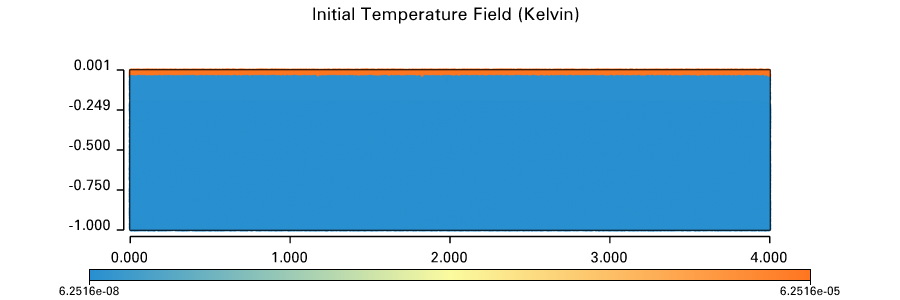

In [16]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
Fig.Points(Model.swarm,Model.viscosityField,pointSize=4.0,colourBar = True)#colours="jet" ,
Fig.show()